# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from tqdm import tqdm
import gc
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from math import floor, ceil
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet

from sklearn.model_selection import StratifiedKFold,KFold,cross_val_score, GridSearchCV,RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold#For splitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, f1_score, roc_auc_score, plot_roc_curve, plot_confusion_matrix, r2_score, mean_absolute_error,mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',None)
#from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


# Reading Dataset

In [2]:
df = pd.read_csv('traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,11/1/2015 0:00,1,15,20151101001
1,11/1/2015 1:00,1,13,20151101011
2,11/1/2015 2:00,1,10,20151101021
3,11/1/2015 3:00,1,7,20151101031
4,11/1/2015 4:00,1,9,20151101041


# Feature Engineering

In [3]:
#Extracting new features for the DateTime Column
df["DateTime"] = pd.to_datetime(df['DateTime'])


df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['day_of_month'] = df['DateTime'].dt.day
#df['Hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['Date']= df['DateTime'].dt.date
df['Time']= df['DateTime'].dt.hour
df['Quarter']=  df['DateTime'].dt.quarter


df['day_of_year']=  df['DateTime'].dt.dayofyear
df['Seconds'] = pd.to_timedelta(df['DateTime'].dt.strftime('%H:%M:%S')).dt.total_seconds().astype(int)


In [4]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Seconds
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,6,2015-11-01,0,4,305,0
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,6,2015-11-01,1,4,305,3600
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,6,2015-11-01,2,4,305,7200
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,6,2015-11-01,3,4,305,10800
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,6,2015-11-01,4,4,305,14400


In [5]:
#Checking DataType of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DateTime      48120 non-null  datetime64[ns]
 1   Junction      48120 non-null  int64         
 2   Vehicles      48120 non-null  int64         
 3   ID            48120 non-null  int64         
 4   Year          48120 non-null  int64         
 5   Month         48120 non-null  int64         
 6   day_of_month  48120 non-null  int64         
 7   day_of_week   48120 non-null  int64         
 8   Date          48120 non-null  object        
 9   Time          48120 non-null  int64         
 10  Quarter       48120 non-null  int64         
 11  day_of_year   48120 non-null  int64         
 12  Seconds       48120 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(10), object(1)
memory usage: 4.6+ MB


In [6]:
df.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'Year', 'Month',
       'day_of_month', 'day_of_week', 'Date', 'Time', 'Quarter', 'day_of_year',
       'Seconds'],
      dtype='object')

In [7]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Seconds
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,6,2015-11-01,0,4,305,0
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,6,2015-11-01,1,4,305,3600
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,6,2015-11-01,2,4,305,7200
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,6,2015-11-01,3,4,305,10800
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,6,2015-11-01,4,4,305,14400


In [8]:
#Encoding the Date Column
L_encoder =LabelEncoder()
df['Date'] = L_encoder.fit_transform(df['Date'])
import pickle
output = open('L_encoder.pkl', 'wb')
pickle.dump(L_encoder, output)
output.close()

In [9]:
df1= df.copy()
#df1= df.set_index('DateTime', drop=True)

In [10]:

# Converting the DateTime Column into integer
df['DateTime'] = df['DateTime'].values.astype(np.int64) / 10 ** 9


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DateTime      48120 non-null  float64
 1   Junction      48120 non-null  int64  
 2   Vehicles      48120 non-null  int64  
 3   ID            48120 non-null  int64  
 4   Year          48120 non-null  int64  
 5   Month         48120 non-null  int64  
 6   day_of_month  48120 non-null  int64  
 7   day_of_week   48120 non-null  int64  
 8   Date          48120 non-null  int32  
 9   Time          48120 non-null  int64  
 10  Quarter       48120 non-null  int64  
 11  day_of_year   48120 non-null  int64  
 12  Seconds       48120 non-null  int32  
dtypes: float64(1), int32(2), int64(10)
memory usage: 4.4 MB


# Creating a Function for Time Series Cross Validation

In [12]:
# Creating a Function to perform Stratified Cross Validation to check for Overfitting
def cross_val(X, y, model, splits=10, seed=42):
    tscv = TimeSeriesSplit(n_splits=splits)

    RMSE_list = [] # a list to store our RMSE scores
    MAPE_list=[]# a list to store our MAPE scores
    MAE_list=[]# a list to store our Accuracy scores
    preds = []  # a list to store our prediction per splits
    model =  model# Instantiate your model

    i = 0
    for train, test in tscv.split(X):
        #X_train, X_test = X[train_index], X[test_index]
        #y_train, y_test = y[train_index], y[test_index]
        x_train, x_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
        model.fit(x_train, y_train)
        RMSE = mean_squared_error(y_test, model.predict(x_test), squared=False)
        MAPE= mean_absolute_percentage_error(y_test, model.predict(x_test))*100
        MAE= mean_absolute_error(y_test, model.predict(x_test))

        print(f'Number of splits trained : {i} \t RMSE:  {RMSE}  \t MAPE: {MAPE}  \t MAE: {MAE}')
        RMSE_list.append(RMSE)
        MAPE_list.append(MAPE)
        MAE_list.append(MAE)
        i += 1
    
    # The mean of our validation scores    
    print('The average RMSE: ', np.mean(RMSE_list))
    print('The average MAPE: ', np.mean(MAPE_list)) 
    print('The average MAE: ', np.mean(MAE_list)) 



    return preds

In [13]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Seconds
0,1.446336e+09,1,15,20151101001,2015,11,1,6,0,0,4,305,0
1,1.446340e+09,1,13,20151101011,2015,11,1,6,0,1,4,305,3600
2,1.446343e+09,1,10,20151101021,2015,11,1,6,0,2,4,305,7200
3,1.446347e+09,1,7,20151101031,2015,11,1,6,0,3,4,305,10800
4,1.446350e+09,1,9,20151101041,2015,11,1,6,0,4,4,305,14400


# Creating New Features by Target Encoding Some Features

In [14]:
#Use Target Encoding to create new features  with aggregates : Std, Max,Min, Mean and Median
def agg_functions(df1):
    features= ['Month','Quarter','day_of_month', 'day_of_week', 'Time', 'day_of_year']
    for x in tqdm(features):
        t=df1.groupby(x)['Vehicles'].agg(['std','max','min','mean','median'])
        t.columns=[x+c+'_vehicles' for c in t.columns]
        t=t.astype({c:np.float32 for c in t.columns})
        t.reset_index(inplace=True)
#         display(t)
        # display(t.T.to_dict('list'))
        df1=df1.merge(t,on=x,how='left')
        gc.collect()
    return df1
# AGGREGATE SPECIFIC FEATURES WITH Vehicless
df2=agg_functions(df)


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.77it/s]


In [15]:
#df2.info()

In [16]:
df2.isnull().sum()

DateTime                       0
Junction                       0
Vehicles                       0
ID                             0
Year                           0
Month                          0
day_of_month                   0
day_of_week                    0
Date                           0
Time                           0
Quarter                        0
day_of_year                    0
Seconds                        0
Monthstd_vehicles              0
Monthmax_vehicles              0
Monthmin_vehicles              0
Monthmean_vehicles             0
Monthmedian_vehicles           0
Quarterstd_vehicles            0
Quartermax_vehicles            0
Quartermin_vehicles            0
Quartermean_vehicles           0
Quartermedian_vehicles         0
day_of_monthstd_vehicles       0
day_of_monthmax_vehicles       0
day_of_monthmin_vehicles       0
day_of_monthmean_vehicles      0
day_of_monthmedian_vehicles    0
day_of_weekstd_vehicles        0
day_of_weekmax_vehicles        0
day_of_wee

In [17]:
#Dropping the IDstd_vehicles which had only NaN values
#df2.drop('IDstd_vehicles', axis=1, inplace = True)

In [18]:
len(df2)

48120

In [19]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Seconds
0,1.446336e+09,1,15,20151101001,2015,11,1,6,0,0,4,305,0
1,1.446340e+09,1,13,20151101011,2015,11,1,6,0,1,4,305,3600
2,1.446343e+09,1,10,20151101021,2015,11,1,6,0,2,4,305,7200
3,1.446347e+09,1,7,20151101031,2015,11,1,6,0,3,4,305,10800
4,1.446350e+09,1,9,20151101041,2015,11,1,6,0,4,4,305,14400


# Seperating the Dataset into 4 for each Junction

In [20]:
df_junc1= df2.loc[df2['Junction']==1]
df_junc2= df2.loc[df2['Junction']==2]
df_junc3= df2.loc[df2['Junction']==3]
df_junc4= df2.loc[df2['Junction']==4]

df_junc1.reset_index(inplace=True, drop=True)
df_junc2.reset_index(inplace=True, drop=True)
df_junc3.reset_index(inplace=True, drop=True)
df_junc4.reset_index(inplace=True, drop=True)


# Building Model for Junction 1

In [21]:
#Declaring Input and Output Variables
X = df_junc1.drop(['Vehicles','Seconds', 'ID', 'Junction'], axis=1)
y = df_junc1['Vehicles']

In [22]:
a= ceil(0.8 * len(df_junc1))

In [23]:
X_train=X.iloc[:a]
y_train= y.iloc[:a]
X_valid=X.iloc[a:]
y_valid=y.iloc[a:]

In [24]:
X_valid.head()#.sum()

,DateTime,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Monthstd_vehicles,...,Timestd_vehicles,Timemax_vehicles,Timemin_vehicles,Timemean_vehicles,Timemedian_vehicles,day_of_yearstd_vehicles,day_of_yearmax_vehicles,day_of_yearmin_vehicles,day_of_yearmean_vehicles,day_of_yearmedian_vehicles
11674,1.488362e+09,2017,3,1,2,486,10,1,60,20.499683,...,20.842903,107.0,1.0,24.229925,15.0,22.523212,98.0,2.0,27.351191,21.0
11675,1.488366e+09,2017,3,1,2,486,11,1,60,20.499683,...,24.142347,136.0,1.0,27.495262,17.0,22.523212,98.0,2.0,27.351191,21.0
11676,1.488370e+09,2017,3,1,2,486,12,1,60,20.499683,...,24.568724,129.0,2.0,28.403990,18.0,22.523212,98.0,2.0,27.351191,21.0
11677,1.488373e+09,2017,3,1,2,486,13,1,60,20.499683,...,21.684610,118.0,2.0,25.588530,17.0,22.523212,98.0,2.0,27.351191,21.0
11678,1.488377e+09,2017,3,1,2,486,14,1,60,20.499683,...,23.902777,162.0,1.0,27.702744,19.0,22.523212,98.0,2.0,27.351191,21.0


# Checking Performance of Baseline Models for Junction 1

In [25]:
#LinearRegression
lg =  LinearRegression()
lg.fit(X_train, y_train)
lg_pred = lg.predict(X_valid)
lg_RMSE = mean_squared_error(y_valid,lg_pred, squared=False)
lg_MAPE= mean_absolute_percentage_error(y_valid,lg_pred)*100

print("LinearRegression RMSE score on validation set is : ",lg_RMSE)
print("LinearRegression MAPE score on validation set is : ",lg_MAPE, '%')

print('--------'*20) 

#LassoRegression
l =  Lasso()
l.fit(X_train, y_train)
l_pred = l.predict(X_valid)
l_RMSE = mean_squared_error(y_valid,l_pred, squared=False)
l_MAPE= mean_absolute_percentage_error(y_valid,l_pred)*100

print("LassoRegression RMSE score on validation set is : ",l_RMSE)
print("LassoRegression MAPE score on validation set is : ",l_MAPE, '%')

print('--------'*20) 

#RidgeRegression
rr =  Ridge()
rr.fit(X_train, y_train)
rr_pred = rr.predict(X_valid)
rr_RMSE = mean_squared_error(y_valid,rr_pred, squared=False)
rr_MAPE= mean_absolute_percentage_error(y_valid,rr_pred)*100

print("RidgeRegression RMSE score on validation set is : ",rr_RMSE)
print("RidgeRegression MAPE score on validation set is : ",rr_MAPE, '%')

print('--------'*20) 


# Catboost
cat = CatBoostRegressor(verbose=False, iterations=100)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)
cat_RMSE = mean_squared_error(y_valid,cat_pred, squared=False)
cat_MAPE= mean_absolute_percentage_error(y_valid,cat_pred)*100

print("CatBoost RMSE score on validation set is : ",cat_RMSE)
print("CatBoost MAPE score on validation set is : ",cat_MAPE, '%')

print('--------'*20)

# LGBM
lgb = LGBMRegressor()#num_iterations=1000)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100

print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')

print('--------'*20)

# XGBoost
xg = XGBRegressor()#n_estimators=1000)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_valid)
xg_RMSE = mean_squared_error(y_valid,xg_pred, squared=False)
xg_MAPE= mean_absolute_percentage_error(y_valid,xg_pred)*100

print("XGBoost RMSE score on validation set is : ",xg_RMSE)
print("XGBoost MAPE score on validation set is : ",xg_MAPE, '%')

print('--------'*20)


#AdaBoost
ab =  AdaBoostRegressor()
ab.fit(X_train, y_train)
ab_pred = ab.predict(X_valid)
ab_RMSE = mean_squared_error(y_valid,ab_pred, squared=False)
ab_MAPE= mean_absolute_percentage_error(y_valid,ab_pred)*100

print("AdaBoost RMSE score on validation set is : ",ab_RMSE)
print("AdaBoost MAPE score on validation set is : ",ab_MAPE, '%')

print('--------'*20)



#Naive Bayes
nb =  GradientBoostingRegressor()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_valid)
nb_RMSE = mean_squared_error(y_valid,nb_pred, squared=False)
nb_MAPE= mean_absolute_percentage_error(y_valid,nb_pred)*100

print("Gradient Boosting RMSE score on validation set is : ",nb_RMSE)
print("Gradient Boosting MAPE score on validation set is : ",nb_MAPE, '%')

print('--------'*20)

#DecisionTree
dt =  DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_valid)
dt_RMSE = mean_squared_error(y_valid,dt_pred, squared=False)
dt_MAPE= mean_absolute_percentage_error(y_valid,dt_pred)*100

print("DecisionTree RMSE score on validation set is : ",dt_RMSE)
print("DecisionTree MAPE score on validation set is : ",dt_MAPE, '%')

print('--------'*20)

#RandomForest
rf =  RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_RMSE = mean_squared_error(y_valid,rf_pred, squared=False)
rf_MAPE= mean_absolute_percentage_error(y_valid,rf_pred)*100

print("RandomForest RMSE score on validation set is : ",rf_RMSE)
print("RandomForest MAPE score on validation set is : ",rf_MAPE, '%')

print('--------'*20)



#SVC
svc =  SVR()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_valid)
svc_RMSE = mean_squared_error(y_valid,svc_pred, squared=False)
svc_MAPE= mean_absolute_percentage_error(y_valid,svc_pred)*100

print("SVC RMSE score on validation set is : ",svc_RMSE)
print("SVC MAPE score on validation set is : ",svc_MAPE, '%')

print('--------'*20)

#LinearSVC
lsvc =  LinearSVR()
lsvc.fit(X_train, y_train)
lsvc_pred = lsvc.predict(X_valid)
lsvc_RMSE = mean_squared_error(y_valid,lsvc_pred, squared=False)
lsvc_MAPE= mean_absolute_percentage_error(y_valid,lsvc_pred)*100
print("LinearSVC RMSE score on validation set is : ",lsvc_RMSE)
print("LinearSVC MAPE score on validation set is : ",lsvc_MAPE, '%')

print('--------'*20)



LinearRegression RMSE score on validation set is :  12.854838049478685
LinearRegression MAPE score on validation set is :  15.230175433082712 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
LassoRegression RMSE score on validation set is :  12.790992639284456
LassoRegression MAPE score on validation set is :  17.673073879384713 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
RidgeRegression RMSE score on validation set is :  12.695813291399535
RidgeRegression MAPE score on validation set is :  15.475676546307163 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
CatBoost RMSE score on validation set is :  17.109869105557205
CatBoost MAPE score on val

## Building Prophet Model for Junction 1

In [26]:
a= ceil(0.8 * len(df_junc1))
a

11674

In [27]:
train=df_junc1.iloc[:a]
test=df_junc1.iloc[a:]

train['DateTime'] =list(df1.loc[df1['Junction']==1]['DateTime'].iloc[:a])
test['DateTime'] =list(df1.loc[df1['Junction']==1]['DateTime'].iloc[a:])

train.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
test.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
train = train.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})
test = test.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [28]:
model = Prophet(yearly_seasonality=True)
for col in train.columns:
    if col != 'y' and col != 'ds':
        model.add_regressor(col)
model.fit(train)


15:56:17 - cmdstanpy - INFO - Chain [1] start processing
15:56:31 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
# making predictions for the next 10 months
X_test = test.drop('y', axis=1)
y_test= test['y']

forecast = model.predict(X_test)
pred = forecast['yhat']
forecast[[ 'ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper' ]].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2017-03-01 10:00:00,72.605001,64.539432,80.722350,95.874947,95.874947,95.874947
1,2017-03-01 11:00:00,78.662582,70.255078,86.539774,95.881063,95.881063,95.881063
2,2017-03-01 12:00:00,79.696021,71.747380,88.753452,95.887179,95.887179,95.887179
3,2017-03-01 13:00:00,73.851131,65.030193,81.725587,95.893295,95.893295,95.893295
4,2017-03-01 14:00:00,77.361132,69.218486,85.623177,95.899411,95.899411,95.899411


In [30]:
prof_MAPE= mean_absolute_percentage_error(y_test,pred)*100
print("Prophet Model MAPE score on validation set is : {:.2f} ".format(prof_MAPE))

Prophet Model MAPE score on validation set is : 14.18 


In [31]:
prof_RMSE= mean_squared_error(y_test,pred, squared=False)
print("Prophet Model RMSE score on validation set is : {:.2f} ".format(prof_RMSE))

Prophet Model RMSE score on validation set is : 13.79 


## Building an ARIMAX Model for Junction 1

In [32]:
df_junc11 = df_junc1.drop(['Seconds', 'ID', 'Junction'], axis=1)
df_junc11['DateTime'] =list(df1.loc[df1['Junction']==1]['DateTime'])

In [33]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

In [34]:
adf_test(df_junc11['Vehicles'])

1. ADF :  -7.148077688287149
2. P-Value :  3.1938429963543334e-10
3. Num Of Lags :  42
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 14549
5. Critical Values :
	 1% :  -3.4307995466445482
	 5% :  -2.8617386797172126
	 10% :  -2.566875752496508


In [35]:
df_junc11.set_index('DateTime', inplace = True, drop = True)

In [36]:
len(test)

2918

In [37]:
df_junc11= df_junc11.reset_index()
a= ceil(0.8 * len(df_junc11))
train=df_junc11.iloc[:a]
test=df_junc11.iloc[a:]
train.set_index('DateTime', inplace=True, drop=True)
test.set_index('DateTime', inplace=True, drop=True)

test.head()

,Vehicles,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Monthstd_vehicles,...,Timestd_vehicles,Timemax_vehicles,Timemin_vehicles,Timemean_vehicles,Timemedian_vehicles,day_of_yearstd_vehicles,day_of_yearmax_vehicles,day_of_yearmin_vehicles,day_of_yearmean_vehicles,day_of_yearmedian_vehicles
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-03-01 10:00:00,74,2017,3,1,2,486,10,1,60,20.499683,...,20.842903,107.0,1.0,24.229925,15.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 11:00:00,84,2017,3,1,2,486,11,1,60,20.499683,...,24.142347,136.0,1.0,27.495262,17.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 12:00:00,87,2017,3,1,2,486,12,1,60,20.499683,...,24.568724,129.0,2.0,28.403990,18.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 13:00:00,78,2017,3,1,2,486,13,1,60,20.499683,...,21.684610,118.0,2.0,25.588530,17.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 14:00:00,82,2017,3,1,2,486,14,1,60,20.499683,...,23.902777,162.0,1.0,27.702744,19.0,22.523212,98.0,2.0,27.351191,21.0


In [38]:
b= []

for col in train.columns:
    if col != 'Vehicles':
        b.append(col)

In [39]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(train['Vehicles'], exogenous = train[b], trace=True,
                          suppress_warnings=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=29.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73801.230, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73405.562, Time=0.94 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73476.352, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73799.235, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73281.894, Time=1.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=73239.872, Time=1.77 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=73225.318, Time=2.57 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=73116.258, Time=4.12 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=71801.080, Time=17.14 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=73216.744, Time=7.12 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=71776.841, Time=29.42 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=30.63 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=41.03 sec
 ARIMA(4,1,3)(0,0,0)[0] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11674
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -35879.485
Date:                Tue, 18 Oct 2022   AIC                          71774.970
Time:                        16:01:42   BIC                          71833.890
Sample:                    11-01-2015   HQIC                         71794.762
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1889      0.042     28.479      0.000       1.107       1.271
ar.L2         -0.2288      0.045     -5.133      0.000      -0.316      -0.141
ar.L3       6.724e-05      0.012      0.006      0.996      -0.023       0.024
ar.L4          0.0182      0.013      1.414      0.157      -0.007       0.044
ar.L5         -0.1555      0.011    -13.959      0.000      -0.177      -0.134
ma.L1         -1.1441      0.042    -27.108      0.000      -1.227      -1.061
ma.L2          0.1879      0.041      4.608      0.000       0.108       0.268
sigma2        27.3695      0.185    147.850      0.000      27.007      27.732
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             24263.60
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Vehicles'], exog = train[b],order=(5,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                11674
Model:                 ARIMA(5, 1, 2)   Log Likelihood              -33245.614
Date:                Tue, 18 Oct 2022   AIC                          66583.228
Time:                        16:03:43   BIC                          66922.019
Sample:                    11-01-2015   HQIC                         66697.030
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Year                         1368.4547    517.347      2.645      0.008     354.474    2382.435
Month                          16.5893    177.356      0.094      0.925    -331.021     364.200
day_of_month                    0.4936      5.723      0.086      0.931     -10.723      11.710
day_of_week                    -0.3428      0.290     -1.184      0.236      -0.910       0.225
Date                           -3.6398      1.669     -2.181      0.029      -6.911      -0.368
Time                           -0.0142      0.037     -0.381      0.703      -0.087       0.059
Quarter                         0.1073      3.651      0.029      0.977      -7.049       7.264
day_of_year                     3.2403      5.824      0.556      0.578      -8.175      14.655
Monthstd_vehicles              -2.3300     26.969     -0.086      0.931     -55.189      50.529
Monthmax_vehicles               0.0117      0.143      0.081      0.935      -0.269       0.292
Monthmin_vehicles               0.8718     11.908      0.073      0.942     -22.467      24.211
Monthmean_vehicles              2.4568     29.246      0.084      0.933     -54.864      59.778
Monthmedian_vehicles           -2.4396     24.028     -0.102      0.919     -49.533      44.654
Quarterstd_vehicles             1.3369     16.016      0.083      0.933     -30.054      32.728
Quartermax_vehicles             0.2087      2.363      0.088      0.930      -4.422       4.840
Quartermin_vehicles         -1.232e-07      0.740  -1.66e-07      1.000      -1.450       1.450
Quartermean_vehicles            0.5826      4.337      0.134      0.893      -7.918       9.083
Quartermedian_vehicles          0.2844      4.474      0.064      0.949      -8.484       9.053
day_of_monthstd_vehicles        0.2227      0.516      0.431      0.666      -0.789       1.235
day_of_monthmax_vehicles       -0.0187      0.013     -1.440      0.150      -0.044       0.007
day_of_monthmin_vehicles       -0.1271      1.221     -0.104      0.917      -2.520       2.266
day_of_monthmean_vehicles       0.1471      0.890      0.165      0.869      -1.598       1.892
day_of_monthmedian_vehicles     0.3481      0.527      0.661      0.509      -0.684       1.380
day_of_weekstd_vehicles         1.3222      1.309      1.010      0.312      -1.243       3.888
day_of_weekmax_vehicles        -0.0207      0.017     -1.218      0.223      -0.054       0.013
day_of_weekmin_vehicles      6.424e-07      0.740   8.68e-07      1.000      -1.450       1.450
day_of_weekmean_vehicles       -1.7034      2.212     -0.770      0.441      -6.040       2.633
day_of_weekmedian_vehicles      0.2530      1.842      0.137      0.891      -3.357       3.863
Timestd_vehicles                0.7053      0.134      5.270      0.000       0.443       0.968
Timemax_vehicles               -0.0144      0.003     -4.272      0.000      -0.021      -0.008
Timemin_vehicles                0.1971      0.078      2.539      0.011  

<AxesSubplot:xlabel='DateTime'>

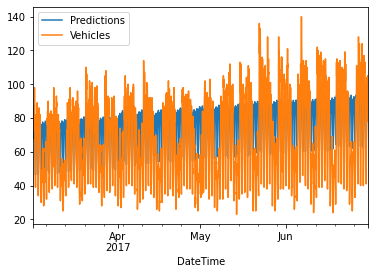

In [41]:
start=len(train)
end=len(train)+len(test)-1
#index_future_dates=pd.date_range(start='2015-11-01',end='2017-06-30')

pred=model.predict(exog = test[b], start=start,end=end,typ='levels').rename('ARIMA predictions')
preds= pd.DataFrame(columns=['DateTime', 'Predictions'])
preds.Predictions = pred
test_index= test.reset_index()
test_index = test_index['DateTime']
preds.DateTime= list (test_index)
preds.set_index('DateTime', inplace=True, drop=True)
#pred.index=list (test_index)
preds.plot(legend=True)
test['Vehicles'].plot(legend=True)

In [42]:
ARIMA_RMSE= mean_squared_error(test['Vehicles'], pred, squared=False)
ARIMA_MAPE= mean_absolute_percentage_error(test['Vehicles'], pred)*100
print("RMSE of ARIMAX:", ARIMA_RMSE)
print("MAPE of ARIMAX:", ARIMA_MAPE)


RMSE of ARIMAX: 18.234103012349156
MAPE of ARIMAX: 28.908571138199175


In [43]:
model_performance = pd.DataFrame({
    "Model": ["LinearRegression","Lasso", "Ridge","CatBoost", "RandomForest", "DecisionTree", "SVR", "LinearSVR", 
              "AdaBoost", "GradientBoosting", "LGBM", "XGBoost", 'Prophet', 'ARIMAX'],
        
    "RMSE": [lg_RMSE, l_RMSE, rr_RMSE, 
              cat_RMSE, rf_RMSE, dt_RMSE, svc_RMSE, lsvc_RMSE, ab_RMSE, nb_RMSE, lgb_RMSE, xg_RMSE, prof_RMSE, ARIMA_RMSE],
    'MAPE': [lg_MAPE, l_MAPE, rr_MAPE, 
              cat_MAPE, rf_MAPE, dt_MAPE, svc_MAPE, lsvc_MAPE, ab_MAPE, nb_MAPE, lgb_MAPE, xg_MAPE, prof_MAPE, ARIMA_MAPE]
    })

model_performance['Average Score']= (model_performance['RMSE']+model_performance['MAPE'])/2

model_performance = model_performance.sort_values(['Average Score'])
    
display(model_performance)

,Model,RMSE,MAPE,Average Score
4,RandomForest,7.010026,7.689260,7.349643
10,LGBM,7.026064,7.906487,7.466276
9,GradientBoosting,7.481111,8.651360,8.066235
11,XGBoost,8.201345,8.987725,8.594535
5,DecisionTree,9.052603,9.769647,9.411125
8,AdaBoost,10.104497,13.934631,12.019564
12,Prophet,13.790623,14.182331,13.986477
0,LinearRegression,12.854838,15.230175,14.042507
2,Ridge,12.695813,15.475677,14.085745
1,Lasso,12.790993,17.673074,15.232033


## Choosing the final model and Tuning it for Junction 1

In [44]:
#Train Test Split using 20% as test size
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) 
# LGBM
X_train=X.iloc[:a]
y_train= y.iloc[:a]
X_valid=X.iloc[a:]
y_valid=y.iloc[a:]
lgb = LGBMRegressor(num_iterations=510, learning_rate= 0.07007)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred) * 100
lgb_MAE= mean_absolute_error(y_valid,lgb_pred)
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE)
print('--------'*20)

Average:  6.621947263547029
LGBM RMSE score on validation set is :  6.112860217926764
LGBM MAPE score on validation set is :  7.131034309167294
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [45]:
len(df_junc1)

14592

### Checking Feature Importance and Removing Useless Features

In [46]:
cat_viz= pd.DataFrame({'Feature':X.columns, 'Importance':lgb.feature_importances_}).sort_values(by="Importance",ascending=False)
cat_viz

,Feature,Importance
6,Time,2354
0,DateTime,1637
29,Timestd_vehicles,1208
34,day_of_yearstd_vehicles,1198
37,day_of_yearmean_vehicles,864
35,day_of_yearmax_vehicles,841
4,day_of_week,837
3,day_of_month,692
8,day_of_year,632
19,day_of_monthstd_vehicles,575


In [47]:
useless_cols1 = list(cat_viz.loc[cat_viz['Importance']==0.00000000000000]['Feature'])
X1= X.drop(useless_cols1,axis=1).reset_index(drop=True)
X_train=X1.iloc[:a]
y_train= y.iloc[:a]
X_valid=X1.iloc[a:]
y_valid=y.iloc[a:]
#Train Test Split using 20% as test size
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) 
# LGBM
#400
lgb = LGBMRegressor(num_iterations=510, learning_rate= 0.07007)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred) *100
lgb_MAE= mean_absolute_error(y_valid,lgb_pred)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE)
print("LGBM MAE score on validation set is : ",lgb_MAE)
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print('--------'*20)

LGBM RMSE score on validation set is :  6.112860217926764
LGBM MAPE score on validation set is :  7.131034309167294
LGBM MAE score on validation set is :  4.60665376811428
Average:  6.621947263547029
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [49]:
useless_cols1

['Quartermedian_vehicles',
 'day_of_weekmin_vehicles',
 'Quartermax_vehicles',
 'Quarter',
 'Quartermin_vehicles',
 'day_of_weekmedian_vehicles']

### Cross Validation for Junction 1

In [50]:
preds = cross_val(X1 ,y , model = LGBMRegressor(num_iterations=510, learning_rate= 0.07007))

Number of splits trained : 0 	 RMSE:  7.875527160979963  	 MAPE: 24.100262470472956  	 MAE: 6.478404850692845
Number of splits trained : 1 	 RMSE:  4.355567392888789  	 MAPE: 11.074684820091374  	 MAE: 3.247619005267393
Number of splits trained : 2 	 RMSE:  5.565704747203247  	 MAPE: 12.034370816536155  	 MAE: 4.186410099874087
Number of splits trained : 3 	 RMSE:  6.302678723182476  	 MAPE: 11.9475164854705  	 MAE: 4.718735879253606
Number of splits trained : 4 	 RMSE:  6.048188311933924  	 MAPE: 10.428536515122962  	 MAE: 4.261334689821138
Number of splits trained : 5 	 RMSE:  5.477699331371405  	 MAPE: 8.705187281067666  	 MAE: 4.193795015092238
Number of splits trained : 6 	 RMSE:  6.506702215909795  	 MAPE: 10.668804470536195  	 MAE: 4.875382174153395
Number of splits trained : 7 	 RMSE:  8.522319246801453  	 MAPE: 9.099592958572455  	 MAE: 5.817488782728709
Number of splits trained : 8 	 RMSE:  5.139340506344902  	 MAPE: 6.867163462700118  	 MAE: 4.009247738609691
Number of split

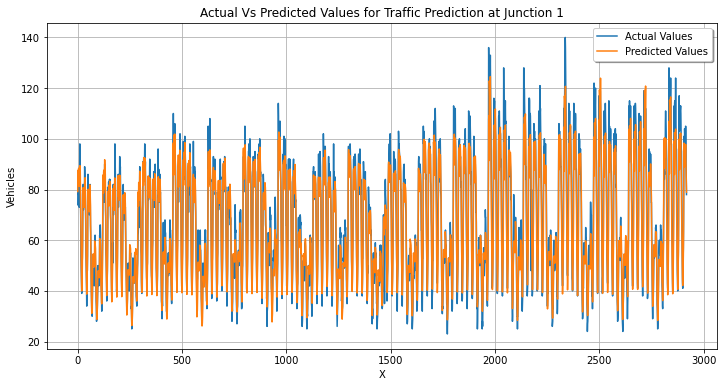

In [51]:
# visualizing in a plot
x_ax = range(len(y_valid))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_valid, label="Actual Values")
plt.plot(x_ax, lgb_pred, label="Predicted Values")
plt.title("Actual Vs Predicted Values for Traffic Prediction at Junction 1")
plt.xlabel('X')
plt.ylabel('Vehicles')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## Exporting the Junction 1 Model

In [52]:
import pickle
pickle_out = open("junction1_model.pkl","wb")
pickle.dump(lgb, pickle_out)
pickle_out.close()

In [53]:
df_junc2.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,...,Timestd_vehicles,Timemax_vehicles,Timemin_vehicles,Timemean_vehicles,Timemedian_vehicles,day_of_yearstd_vehicles,day_of_yearmax_vehicles,day_of_yearmin_vehicles,day_of_yearmean_vehicles,day_of_yearmedian_vehicles
0,1.446336e+09,2,6,20151101002,2015,11,1,6,0,0,...,19.148046,109.0,1.0,23.540648,16.0,17.197771,77.0,1.0,16.701389,11.0
1,1.446340e+09,2,6,20151101012,2015,11,1,6,0,1,...,16.310963,81.0,1.0,19.654863,13.0,17.197771,77.0,1.0,16.701389,11.0
2,1.446343e+09,2,5,20151101022,2015,11,1,6,0,2,...,14.159041,69.0,1.0,17.102743,11.0,17.197771,77.0,1.0,16.701389,11.0
3,1.446347e+09,2,6,20151101032,2015,11,1,6,0,3,...,12.333346,57.0,1.0,14.847382,10.0,17.197771,77.0,1.0,16.701389,11.0
4,1.446350e+09,2,7,20151101042,2015,11,1,6,0,4,...,10.668347,48.0,1.0,12.973067,9.0,17.197771,77.0,1.0,16.701389,11.0


# Building Model for Junction 2

In [54]:
X = df_junc2.drop(['Vehicles','Seconds', 'ID', 'Junction'], axis=1)
y = df_junc2['Vehicles']

In [55]:
a= ceil(0.8 * len(df_junc2))

In [56]:
X_train=X.iloc[:a]
y_train= y.iloc[:a]
X_valid=X.iloc[a:]
y_valid=y.iloc[a:]

# Checking Performance of Baseline Models for Junction 2

In [57]:
#LinearRegression
lg =  LinearRegression()
lg.fit(X_train, y_train)
lg_pred = lg.predict(X_valid)
lg_RMSE = mean_squared_error(y_valid,lg_pred, squared=False)
lg_MAPE= mean_absolute_percentage_error(y_valid,lg_pred)*100

print("LinearRegression RMSE score on validation set is : ",lg_RMSE)
print("LinearRegression MAPE score on validation set is : ",lg_MAPE, '%')

print('--------'*20) 

#LassoRegression
l =  Lasso()
l.fit(X_train, y_train)
l_pred = l.predict(X_valid)
l_RMSE = mean_squared_error(y_valid,l_pred, squared=False)
l_MAPE= mean_absolute_percentage_error(y_valid,l_pred)*100

print("LassoRegression RMSE score on validation set is : ",l_RMSE)
print("LassoRegression MAPE score on validation set is : ",l_MAPE, '%')

print('--------'*20) 

#RidgeRegression
rr =  Ridge()
rr.fit(X_train, y_train)
rr_pred = rr.predict(X_valid)
rr_RMSE = mean_squared_error(y_valid,rr_pred, squared=False)
rr_MAPE= mean_absolute_percentage_error(y_valid,rr_pred)*100

print("RidgeRegression RMSE score on validation set is : ",rr_RMSE)
print("RidgeRegression MAPE score on validation set is : ",rr_MAPE, '%')

print('--------'*20) 


# Catboost
cat = CatBoostRegressor(verbose=False, iterations=100)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)
cat_RMSE = mean_squared_error(y_valid,cat_pred, squared=False)
cat_MAPE= mean_absolute_percentage_error(y_valid,cat_pred)*100

print("CatBoost RMSE score on validation set is : ",cat_RMSE)
print("CatBoost MAPE score on validation set is : ",cat_MAPE, '%')

print('--------'*20)

# LGBM
lgb = LGBMRegressor()#num_iterations=1000)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100

print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')

print('--------'*20)

# XGBoost
xg = XGBRegressor()#n_estimators=1000)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_valid)
xg_RMSE = mean_squared_error(y_valid,xg_pred, squared=False)
xg_MAPE= mean_absolute_percentage_error(y_valid,xg_pred)*100

print("XGBoost RMSE score on validation set is : ",xg_RMSE)
print("XGBoost MAPE score on validation set is : ",xg_MAPE, '%')

print('--------'*20)


#AdaBoost
ab =  AdaBoostRegressor()
ab.fit(X_train, y_train)
ab_pred = ab.predict(X_valid)
ab_RMSE = mean_squared_error(y_valid,ab_pred, squared=False)
ab_MAPE= mean_absolute_percentage_error(y_valid,ab_pred)*100

print("AdaBoost RMSE score on validation set is : ",ab_RMSE)
print("AdaBoost MAPE score on validation set is : ",ab_MAPE, '%')

print('--------'*20)



#Naive Bayes
nb =  GradientBoostingRegressor()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_valid)
nb_RMSE = mean_squared_error(y_valid,nb_pred, squared=False)
nb_MAPE= mean_absolute_percentage_error(y_valid,nb_pred)*100

print("Gradient Boosting RMSE score on validation set is : ",nb_RMSE)
print("Gradient Boosting MAPE score on validation set is : ",nb_MAPE, '%')

print('--------'*20)

#DecisionTree
dt =  DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_valid)
dt_RMSE = mean_squared_error(y_valid,dt_pred, squared=False)
dt_MAPE= mean_absolute_percentage_error(y_valid,dt_pred)*100

print("DecisionTree RMSE score on validation set is : ",dt_RMSE)
print("DecisionTree MAPE score on validation set is : ",dt_MAPE, '%')

print('--------'*20)

#RandomForest
rf =  RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_RMSE = mean_squared_error(y_valid,rf_pred, squared=False)
rf_MAPE= mean_absolute_percentage_error(y_valid,rf_pred)*100

print("RandomForest RMSE score on validation set is : ",rf_RMSE)
print("RandomForest MAPE score on validation set is : ",rf_MAPE, '%')

print('--------'*20)





#SVC
svc =  SVR()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_valid)
svc_RMSE = mean_squared_error(y_valid,svc_pred, squared=False)
svc_MAPE= mean_absolute_percentage_error(y_valid,svc_pred)*100

print("SVC RMSE score on validation set is : ",svc_RMSE)
print("SVC MAPE score on validation set is : ",svc_MAPE, '%')

print('--------'*20)

#LinearSVC
lsvc =  LinearSVR()
lsvc.fit(X_train, y_train)
lsvc_pred = lsvc.predict(X_valid)
lsvc_RMSE = mean_squared_error(y_valid,lsvc_pred, squared=False)
lsvc_MAPE= mean_absolute_percentage_error(y_valid,lsvc_pred)*100
print("LinearSVC RMSE score on validation set is : ",lsvc_RMSE)
print("LinearSVC MAPE score on validation set is : ",lsvc_MAPE, '%')

print('--------'*20)



LinearRegression RMSE score on validation set is :  7.6277505677670785
LinearRegression MAPE score on validation set is :  21.368942379124352 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
LassoRegression RMSE score on validation set is :  8.612488048386004
LassoRegression MAPE score on validation set is :  25.109017538807727 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
RidgeRegression RMSE score on validation set is :  7.9319416804565686
RidgeRegression MAPE score on validation set is :  22.272597036913595 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
CatBoost RMSE score on validation set is :  7.177207066865056
CatBoost MAPE score on valid

## Building Prophet Model for Junction 2

In [58]:
a= ceil(0.8 * len(df_junc2))
a

11674

In [59]:
train=df_junc2.iloc[:a]
test=df_junc2.iloc[a:]

train['DateTime'] =list(df1.loc[df1['Junction']==2]['DateTime'].iloc[:a])
test['DateTime'] =list(df1.loc[df1['Junction']==2]['DateTime'].iloc[a:])

train.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
test.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
train = train.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})
test = test.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [60]:
model = Prophet(yearly_seasonality=True)
for col in train.columns:
    if col != 'y' and col != 'ds':
        model.add_regressor(col)
model.fit(train)


16:14:06 - cmdstanpy - INFO - Chain [1] start processing
16:14:22 - cmdstanpy - INFO - Chain [1] done processing


In [61]:
# making predictions for the next 10 months
X_test = test.drop('y', axis=1)
y_test= test['y']

forecast = model.predict(X_test)
pred = forecast['yhat']
forecast[[ 'ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper' ]].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2017-03-01 10:00:00,22.599683,19.462826,25.900721,3.588443,3.588443,3.588443
1,2017-03-01 11:00:00,23.431177,20.177139,26.686667,3.589379,3.589379,3.589379
2,2017-03-01 12:00:00,24.199716,21.062760,27.373747,3.590316,3.590316,3.590316
3,2017-03-01 13:00:00,23.551008,20.367658,26.729055,3.591252,3.591252,3.591252
4,2017-03-01 14:00:00,24.738518,21.615235,27.805379,3.592188,3.592188,3.592188


In [62]:
prof_MAPE= mean_absolute_percentage_error(y_test,pred)*100
print("Prophet Model MAPE score on validation set is : {:.2f} ".format(prof_MAPE))

Prophet Model MAPE score on validation set is : 29.84 


In [63]:
prof_RMSE= mean_squared_error(y_test,pred, squared=False)
print("Prophet Model RMSE score on validation set is : {:.2f} ".format(prof_RMSE))

Prophet Model RMSE score on validation set is : 6.58 


## Building an ARIMAX Model for Junction 2

In [64]:
df_junc21 = df_junc2.drop(['Seconds', 'ID', 'Junction'], axis=1)
df_junc21['DateTime'] =list(df1.loc[df1['Junction']==2]['DateTime'])

In [65]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

In [66]:
adf_test(df_junc21['Vehicles'])

1. ADF :  -8.041077275597695
2. P-Value :  1.8463683667707697e-12
3. Num Of Lags :  42
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 14549
5. Critical Values :
	 1% :  -3.4307995466445482
	 5% :  -2.8617386797172126
	 10% :  -2.566875752496508


In [67]:
df_junc21.set_index('DateTime', inplace = True, drop = True)

In [68]:
df_junc21= df_junc21.reset_index()
a= ceil(0.8 * len(df_junc21))
train=df_junc21.iloc[:a]
test=df_junc21.iloc[a:]
train.set_index('DateTime', inplace=True, drop=True)
test.set_index('DateTime', inplace=True, drop=True)

test.head()

,Vehicles,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Monthstd_vehicles,...,Timestd_vehicles,Timemax_vehicles,Timemin_vehicles,Timemean_vehicles,Timemedian_vehicles,day_of_yearstd_vehicles,day_of_yearmax_vehicles,day_of_yearmin_vehicles,day_of_yearmean_vehicles,day_of_yearmedian_vehicles
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-03-01 10:00:00,21,2017,3,1,2,486,10,1,60,20.499683,...,20.842903,107.0,1.0,24.229925,15.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 11:00:00,25,2017,3,1,2,486,11,1,60,20.499683,...,24.142347,136.0,1.0,27.495262,17.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 12:00:00,22,2017,3,1,2,486,12,1,60,20.499683,...,24.568724,129.0,2.0,28.403990,18.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 13:00:00,23,2017,3,1,2,486,13,1,60,20.499683,...,21.684610,118.0,2.0,25.588530,17.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 14:00:00,27,2017,3,1,2,486,14,1,60,20.499683,...,23.902777,162.0,1.0,27.702744,19.0,22.523212,98.0,2.0,27.351191,21.0


In [69]:
b= []

for col in train.columns:
    if col != 'Vehicles':
        b.append(col)

In [70]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(train['Vehicles'], exogenous = train[b], trace=True,
                          suppress_warnings=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=12.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56748.287, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=55145.310, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=55048.151, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56746.291, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=55012.200, Time=1.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=54998.186, Time=2.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=54996.239, Time=0.77 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=54998.165, Time=1.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=54998.563, Time=9.46 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=54994.248, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=55143.318, Time=0.30 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=54996.173, Time=0.65 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=54996.195, Time=1.22 sec
 ARIMA(1,1,1)(0,0,0)[0] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11674
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -27494.124
Date:                Tue, 18 Oct 2022   AIC                          54994.248
Time:                        16:15:02   BIC                          55016.343
Sample:                    11-01-2015   HQIC                         55001.670
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3992      0.008    -49.638      0.000      -0.415      -0.383
ar.L2         -0.1134      0.009    -13.072      0.000      -0.130      -0.096
sigma2         6.5069      0.072     90.305      0.000       6.366       6.648
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               423.38
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Vehicles'], exog = train[b],order=(2,1,0))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                11674
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -26405.504
Date:                Tue, 18 Oct 2022   AIC                          52893.008
Time:                        16:16:19   BIC                          53194.974
Sample:                    11-01-2015   HQIC                         52994.440
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Year                          324.3000   1321.182      0.245      0.806   -2265.169    2913.769
Month                           2.7265     54.370      0.050      0.960    -103.837     109.290
day_of_month                    0.0617      1.773      0.035      0.972      -3.413       3.536
day_of_week                    -0.3192      0.116     -2.755      0.006      -0.546      -0.092
Date                           -0.8453      3.633     -0.233      0.816      -7.966       6.275
Time                           -0.0189      0.013     -1.444      0.149      -0.045       0.007
Quarter                         0.0075      0.485      0.016      0.988      -0.943       0.958
day_of_year                     0.8297      3.166      0.262      0.793      -5.375       7.034
Monthstd_vehicles              -1.6193      5.652     -0.287      0.774     -12.697       9.458
Monthmax_vehicles               0.0180      0.047      0.385      0.700      -0.074       0.110
Monthmin_vehicles               0.4428      3.088      0.143      0.886      -5.609       6.495
Monthmean_vehicles              1.5576      5.969      0.261      0.794     -10.142      13.257
Monthmedian_vehicles           -0.8625      5.006     -0.172      0.863     -10.674       8.949
Quarterstd_vehicles             0.3070      3.539      0.087      0.931      -6.630       7.244
Quartermax_vehicles             0.1535      0.512      0.300      0.765      -0.851       1.158
Quartermin_vehicles          1.452e-08        nan        nan        nan         nan         nan
Quartermean_vehicles            0.2501      0.860      0.291      0.771      -1.435       1.936
Quartermedian_vehicles          0.1563      0.911      0.172      0.864      -1.629       1.942
day_of_monthstd_vehicles       -0.1034      0.211     -0.490      0.624      -0.517       0.310
day_of_monthmax_vehicles        0.0049      0.006      0.800      0.424      -0.007       0.017
day_of_monthmin_vehicles       -0.4293      0.431     -0.996      0.319      -1.274       0.415
day_of_monthmean_vehicles       0.0638      0.385      0.166      0.869      -0.691       0.819
day_of_monthmedian_vehicles     0.0650      0.241      0.270      0.787      -0.408       0.538
day_of_weekstd_vehicles        -0.4432      0.551     -0.805      0.421      -1.523       0.636
day_of_weekmax_vehicles     -3.398e-05      0.007     -0.005      0.996      -0.014       0.014
day_of_weekmin_vehicles     -7.786e-08        nan        nan        nan         nan         nan
day_of_weekmean_vehicles        0.4048      0.934      0.434      0.665      -1.425       2.235
day_of_weekmedian_vehicles     -0.1189      0.791     -0.150      0.881      -1.669       1.431
Timestd_vehicles               -0.6244      0.071     -8.787      0.000      -0.764      -0.485
Timemax_vehicles                0.0097      0.002      5.107      0.000       0.006       0.013
Timemin_vehicles                0.0444      0.047      0.950      0.342  

<AxesSubplot:xlabel='DateTime'>

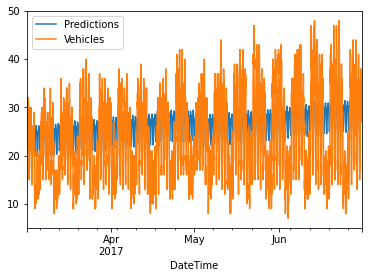

In [72]:
start=len(train)
end=len(train)+len(test)-1
#index_future_dates=pd.date_range(start='2015-11-01',end='2017-06-30')

pred=model.predict(exog = test[b], start=start,end=end,typ='levels').rename('ARIMA predictions')
preds= pd.DataFrame(columns=['DateTime', 'Predictions'])
preds.Predictions = pred
test_index= test.reset_index()
test_index = test_index['DateTime']
preds.DateTime= list (test_index)
preds.set_index('DateTime', inplace=True, drop=True)
#pred.index=list (test_index)
preds.plot(legend=True)
test['Vehicles'].plot(legend=True)

In [73]:
ARIMA_RMSE= mean_squared_error(test['Vehicles'], pred, squared=False)
ARIMA_MAPE= mean_absolute_percentage_error(test['Vehicles'], pred)*100
print("RMSE of ARIMAX:", ARIMA_RMSE)
print("MAPE of ARIMAX:", ARIMA_MAPE)


RMSE of ARIMAX: 7.391952155631057
MAPE of ARIMAX: 33.85545835566006


In [74]:
model_performance = pd.DataFrame({
    "Model": ["LinearRegression","Lasso", "Ridge","CatBoost", "RandomForest", "DecisionTree", "SVR", "LinearSVR", 
              "AdaBoost", "GradientBoosting", "LGBM", "XGBoost", 'Prophet', 'ARIMAX'],
        
    "RMSE": [lg_RMSE, l_RMSE, rr_RMSE, 
              cat_RMSE, rf_RMSE, dt_RMSE, svc_RMSE, lsvc_RMSE, ab_RMSE, nb_RMSE, lgb_RMSE, xg_RMSE, prof_RMSE, ARIMA_RMSE],
    'MAPE': [lg_MAPE, l_MAPE, rr_MAPE, 
              cat_MAPE, rf_MAPE, dt_MAPE, svc_MAPE, lsvc_MAPE, ab_MAPE, nb_MAPE, lgb_MAPE, xg_MAPE, prof_MAPE, ARIMA_MAPE]
    })

model_performance['Average Score']= (model_performance['RMSE']+model_performance['MAPE'])/2

model_performance = model_performance.sort_values(['Average Score'])
    
display(model_performance)

,Model,RMSE,MAPE,Average Score
10,LGBM,4.583478,13.839091,9.211284
4,RandomForest,4.932235,15.287121,10.109678
11,XGBoost,4.632021,15.688251,10.160136
9,GradientBoosting,5.061104,15.636265,10.348685
5,DecisionTree,5.617521,17.554998,11.586259
8,AdaBoost,5.839895,19.045331,12.442613
3,CatBoost,7.177207,19.705083,13.441145
0,LinearRegression,7.627751,21.368942,14.498346
2,Ridge,7.931942,22.272597,15.102269
1,Lasso,8.612488,25.109018,16.860753


## Choosing the final model and Tuning it for Junction 2

In [75]:
# LGBM
lgb = LGBMRegressor(num_iterations=170, learning_rate=0.08902)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')
print('--------'*20)


Average:  8.952396385681087
LGBM RMSE score on validation set is :  4.383629187782985
LGBM MAPE score on validation set is :  13.521163583579188 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------


### Checking Feature Importance and Removing Useless Features

In [76]:
cat_viz= pd.DataFrame({'Feature':X.columns, 'Importance':lgb.feature_importances_}).sort_values(by="Importance",ascending=False)
cat_viz

,Feature,Importance
6,Time,715
0,DateTime,482
34,day_of_yearstd_vehicles,364
29,Timestd_vehicles,361
4,day_of_week,349
37,day_of_yearmean_vehicles,321
8,day_of_year,265
35,day_of_yearmax_vehicles,256
38,day_of_yearmedian_vehicles,234
3,day_of_month,206


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

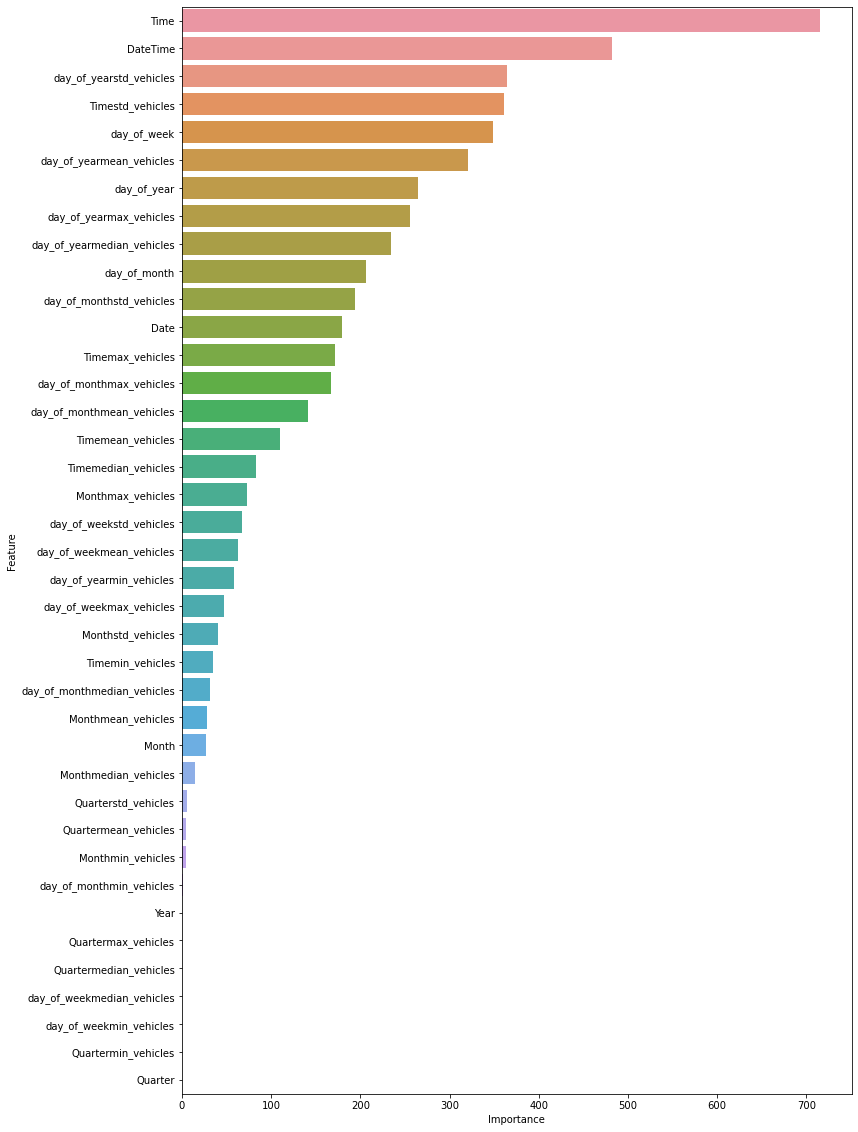

In [77]:
plt.figure(figsize= (12,20))
sns.barplot(x='Importance', y= 'Feature', data=cat_viz, label="Feature Importances", orient= 'h')#, color_palette='tab10')
#sns.set_color_palette('hls', 8)

In [78]:
useless_cols2 = list(cat_viz.loc[cat_viz['Importance']==0.00000000000000]['Feature'])
X1= X.drop(useless_cols2,axis=1).reset_index(drop=True)
X_train=X1.iloc[:a]
y_train= y.iloc[:a]
X_valid=X1.iloc[a:]
y_valid=y.iloc[a:]

lgb = LGBMRegressor(num_iterations=170, learning_rate=0.08902)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')
print('-------'*20)

Average:  8.952396385681087
LGBM RMSE score on validation set is :  4.383629187782985
LGBM MAPE score on validation set is :  13.521163583579188 %
--------------------------------------------------------------------------------------------------------------------------------------------


In [79]:
useless_cols2

['Year',
 'Quartermax_vehicles',
 'Quartermedian_vehicles',
 'day_of_weekmedian_vehicles',
 'day_of_weekmin_vehicles',
 'Quartermin_vehicles',
 'Quarter']

### Cross Validation for Junction 2

In [80]:
preds = cross_val(X1 ,y , model =LGBMRegressor(num_iterations=170, learning_rate=0.08902))

Number of splits trained : 0 	 RMSE:  3.764167507131716  	 MAPE: 32.94729892204427  	 MAE: 2.9586348256051607
Number of splits trained : 1 	 RMSE:  2.1154416307433364  	 MAPE: 17.92316092629691  	 MAE: 1.7118152819401256
Number of splits trained : 2 	 RMSE:  2.2773058778642716  	 MAPE: 16.852599012506385  	 MAE: 1.8345234424478134
Number of splits trained : 3 	 RMSE:  2.0876133185844643  	 MAPE: 16.73343025016025  	 MAE: 1.6742501324615036
Number of splits trained : 4 	 RMSE:  2.8768364161892377  	 MAPE: 35.32600355891437  	 MAE: 2.0448227505394407
Number of splits trained : 5 	 RMSE:  3.5517098389384447  	 MAPE: 19.686430311541542  	 MAE: 2.7491292378301115
Number of splits trained : 6 	 RMSE:  2.9623656088532613  	 MAPE: 20.47235962601304  	 MAE: 2.2767488610110327
Number of splits trained : 7 	 RMSE:  5.670934231566241  	 MAPE: 23.831022983620322  	 MAE: 4.63839958283375
Number of splits trained : 8 	 RMSE:  3.7631039335568897  	 MAPE: 12.738514076401364  	 MAE: 2.9116881190293964
N

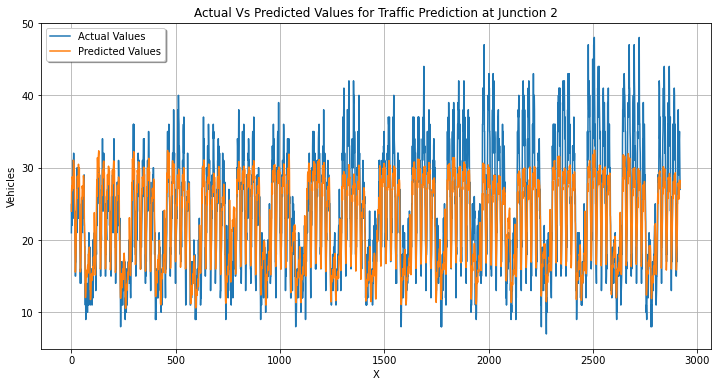

In [81]:
# visualizing in a plot
x_ax = range(len(y_valid))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_valid, label="Actual Values")
plt.plot(x_ax, lgb_pred, label="Predicted Values")
plt.title("Actual Vs Predicted Values for Traffic Prediction at Junction 2")
plt.xlabel('X')
plt.ylabel('Vehicles')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## Exporting the Junction 2 Model

In [82]:
import pickle
pickle_out = open("junction2_model.pkl","wb")
pickle.dump(lgb, pickle_out)
pickle_out.close()

# Building Model for Junction 3

In [83]:
X = df_junc3.drop(['Vehicles','Seconds', 'ID', 'Junction'], axis=1)
y = df_junc3['Vehicles']

In [84]:
a= ceil(0.8 * len(df_junc3))

In [85]:
X_train=X.iloc[:a]
y_train= y.iloc[:a]
X_valid=X.iloc[a:]
y_valid=y.iloc[a:]

# Checking Performance of Baseline Models for Junction 3

In [86]:
#LinearRegression
lg =  LinearRegression()
lg.fit(X_train, y_train)
lg_pred = lg.predict(X_valid)
lg_RMSE = mean_squared_error(y_valid,lg_pred, squared=False)
lg_MAPE= mean_absolute_percentage_error(y_valid,lg_pred)*100

print("LinearRegression RMSE score on validation set is : ",lg_RMSE)
print("LinearRegression MAPE score on validation set is : ",lg_MAPE, '%')

print('--------'*20) 

#LassoRegression
l =  Lasso()
l.fit(X_train, y_train)
l_pred = l.predict(X_valid)
l_RMSE = mean_squared_error(y_valid,l_pred, squared=False)
l_MAPE= mean_absolute_percentage_error(y_valid,l_pred)*100

print("LassoRegression RMSE score on validation set is : ",l_RMSE)
print("LassoRegression MAPE score on validation set is : ",l_MAPE, '%')

print('--------'*20) 

#RidgeRegression
rr =  Ridge()
rr.fit(X_train, y_train)
rr_pred = rr.predict(X_valid)
rr_RMSE = mean_squared_error(y_valid,rr_pred, squared=False)
rr_MAPE= mean_absolute_percentage_error(y_valid,rr_pred)*100

print("RidgeRegression RMSE score on validation set is : ",rr_RMSE)
print("RidgeRegression MAPE score on validation set is : ",rr_MAPE, '%')

print('--------'*20) 


# Catboost
cat = CatBoostRegressor(verbose=False, iterations=100)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)
cat_RMSE = mean_squared_error(y_valid,cat_pred, squared=False)
cat_MAPE= mean_absolute_percentage_error(y_valid,cat_pred)*100

print("CatBoost RMSE score on validation set is : ",cat_RMSE)
print("CatBoost MAPE score on validation set is : ",cat_MAPE, '%')

print('--------'*20)

# LGBM
lgb = LGBMRegressor()#num_iterations=1000)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100

print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')

print('--------'*20)

# XGBoost
xg = XGBRegressor()#n_estimators=1000)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_valid)
xg_RMSE = mean_squared_error(y_valid,xg_pred, squared=False)
xg_MAPE= mean_absolute_percentage_error(y_valid,xg_pred)*100

print("XGBoost RMSE score on validation set is : ",xg_RMSE)
print("XGBoost MAPE score on validation set is : ",xg_MAPE, '%')

print('--------'*20)


#AdaBoost
ab =  AdaBoostRegressor()
ab.fit(X_train, y_train)
ab_pred = ab.predict(X_valid)
ab_RMSE = mean_squared_error(y_valid,ab_pred, squared=False)
ab_MAPE= mean_absolute_percentage_error(y_valid,ab_pred)*100

print("AdaBoost RMSE score on validation set is : ",ab_RMSE)
print("AdaBoost MAPE score on validation set is : ",ab_MAPE, '%')

print('--------'*20)



#Naive Bayes
nb =  GradientBoostingRegressor()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_valid)
nb_RMSE = mean_squared_error(y_valid,nb_pred, squared=False)
nb_MAPE= mean_absolute_percentage_error(y_valid,nb_pred)*100

print("Gradient Boosting RMSE score on validation set is : ",nb_RMSE)
print("Gradient Boosting MAPE score on validation set is : ",nb_MAPE, '%')

print('--------'*20)

#DecisionTree
dt =  DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_valid)
dt_RMSE = mean_squared_error(y_valid,dt_pred, squared=False)
dt_MAPE= mean_absolute_percentage_error(y_valid,dt_pred)*100

print("DecisionTree RMSE score on validation set is : ",dt_RMSE)
print("DecisionTree MAPE score on validation set is : ",dt_MAPE, '%')

print('--------'*20)

#RandomForest
rf =  RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_RMSE = mean_squared_error(y_valid,rf_pred, squared=False)
rf_MAPE= mean_absolute_percentage_error(y_valid,rf_pred)*100

print("RandomForest RMSE score on validation set is : ",rf_RMSE)
print("RandomForest MAPE score on validation set is : ",rf_MAPE, '%')

print('--------'*20)



#SVC
svc =  SVR()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_valid)
svc_RMSE = mean_squared_error(y_valid,svc_pred, squared=False)
svc_MAPE= mean_absolute_percentage_error(y_valid,svc_pred)*100

print("SVC RMSE score on validation set is : ",svc_RMSE)
print("SVC MAPE score on validation set is : ",svc_MAPE, '%')

print('--------'*20)

#LinearSVC
lsvc =  LinearSVR()
lsvc.fit(X_train, y_train)
lsvc_pred = lsvc.predict(X_valid)
lsvc_RMSE = mean_squared_error(y_valid,lsvc_pred, squared=False)
lsvc_MAPE= mean_absolute_percentage_error(y_valid,lsvc_pred)*100
print("LinearSVC RMSE score on validation set is : ",lsvc_RMSE)
print("LinearSVC MAPE score on validation set is : ",lsvc_MAPE, '%')

print('--------'*20)



LinearRegression RMSE score on validation set is :  8.41861572088234
LinearRegression MAPE score on validation set is :  41.727789384930176 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
LassoRegression RMSE score on validation set is :  8.581688626614895
LassoRegression MAPE score on validation set is :  49.20684317335338 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
RidgeRegression RMSE score on validation set is :  8.529474802839362
RidgeRegression MAPE score on validation set is :  44.6548040422754 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
CatBoost RMSE score on validation set is :  10.028168824555438
CatBoost MAPE score on validation

## Building Prophet Model for Junction 3

In [87]:
a= ceil(0.8 * len(df_junc3))
a

11674

In [88]:
train=df_junc3.iloc[:a]
test=df_junc3.iloc[a:]

train['DateTime'] =list(df1.loc[df1['Junction']==3]['DateTime'].iloc[:a])
test['DateTime'] =list(df1.loc[df1['Junction']==3]['DateTime'].iloc[a:])

train.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
test.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
train = train.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})
test = test.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [89]:
model = Prophet(yearly_seasonality=True)
for col in train.columns:
    if col != 'y' and col != 'ds':
        model.add_regressor(col)
model.fit(train)


16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:40 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
# making predictions for the next 10 months
X_test = test.drop('y', axis=1)
y_test= test['y']

forecast = model.predict(X_test)
pred = forecast['yhat']
forecast[[ 'ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper' ]].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2017-03-01 10:00:00,29.171365,20.236417,38.398754,57.335176,57.335176,57.335176
1,2017-03-01 11:00:00,31.250818,22.049685,40.042734,57.341316,57.341316,57.341316
2,2017-03-01 12:00:00,31.653730,21.664232,41.234414,57.347456,57.347456,57.347456
3,2017-03-01 13:00:00,30.048950,20.758070,38.829114,57.353596,57.353596,57.353596
4,2017-03-01 14:00:00,31.589929,21.853669,41.288701,57.359735,57.359735,57.359735


In [91]:
prof_MAPE= mean_absolute_percentage_error(y_test,pred)*100
print("Prophet Model MAPE score on validation set is : {:.2f} ".format(prof_MAPE))

Prophet Model MAPE score on validation set is : 122.27 


In [92]:
prof_RMSE= mean_squared_error(y_test,pred, squared=False)
print("Prophet Model RMSE score on validation set is : {:.2f} ".format(prof_RMSE))

Prophet Model RMSE score on validation set is : 15.94 


## Building an ARIMAX Model for Junction 3

In [93]:
df_junc31 = df_junc3.drop(['Seconds', 'ID', 'Junction'], axis=1)
#dfa= 
df_junc31['DateTime'] =list(df1.loc[df1['Junction']==3]['DateTime'])

In [94]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

In [95]:
adf_test(df_junc31['Vehicles'])

1. ADF :  -8.23660035369922
2. P-Value :  5.867295855828129e-13
3. Num Of Lags :  42
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 14549
5. Critical Values :
	 1% :  -3.4307995466445482
	 5% :  -2.8617386797172126
	 10% :  -2.566875752496508


In [96]:
df_junc31.set_index('DateTime', inplace = True, drop = True)

In [97]:
df_junc31= df_junc31.reset_index()
a= ceil(0.8 * len(df_junc31))
train=df_junc31.iloc[:a]
test=df_junc31.iloc[a:]
train.set_index('DateTime', inplace=True, drop=True)
test.set_index('DateTime', inplace=True, drop=True)

test.head()

,Vehicles,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Monthstd_vehicles,...,Timestd_vehicles,Timemax_vehicles,Timemin_vehicles,Timemean_vehicles,Timemedian_vehicles,day_of_yearstd_vehicles,day_of_yearmax_vehicles,day_of_yearmin_vehicles,day_of_yearmean_vehicles,day_of_yearmedian_vehicles
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-03-01 10:00:00,16,2017,3,1,2,486,10,1,60,20.499683,...,20.842903,107.0,1.0,24.229925,15.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 11:00:00,27,2017,3,1,2,486,11,1,60,20.499683,...,24.142347,136.0,1.0,27.495262,17.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 12:00:00,29,2017,3,1,2,486,12,1,60,20.499683,...,24.568724,129.0,2.0,28.403990,18.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 13:00:00,19,2017,3,1,2,486,13,1,60,20.499683,...,21.684610,118.0,2.0,25.588530,17.0,22.523212,98.0,2.0,27.351191,21.0
2017-03-01 14:00:00,30,2017,3,1,2,486,14,1,60,20.499683,...,23.902777,162.0,1.0,27.702744,19.0,22.523212,98.0,2.0,27.351191,21.0


In [98]:
b= []

for col in train.columns:
    if col != 'Vehicles':
        b.append(col)

In [99]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(train['Vehicles'], exogenous = train[b], trace=True,
                          suppress_warnings=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=72361.785, Time=24.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=73617.968, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=73617.061, Time=0.93 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=73616.494, Time=1.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=73615.968, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=72420.975, Time=7.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=72412.844, Time=12.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=72416.033, Time=34.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=72424.951, Time=16.74 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=72517.364, Time=5.63 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=72413.478, Time=13.56 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=72401.148, Time=13.01 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=27.36 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=72204.420, Time=7.33 sec
 ARIMA(1,1,2)(0,0,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11674
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -36097.210
Date:                Tue, 18 Oct 2022   AIC                          72204.420
Time:                        16:21:14   BIC                          72241.245
Sample:                    11-01-2015   HQIC                         72216.790
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7163      0.008    219.444      0.000       1.701       1.732
ar.L2         -0.7763      0.006   -131.409      0.000      -0.788      -0.765
ma.L1         -1.8563      0.009   -213.587      0.000      -1.873      -1.839
ma.L2          0.8657      0.008    103.528      0.000       0.849       0.882
sigma2        28.4091      0.065    437.588      0.000      28.282      28.536
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):           2318023.99
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                             4.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Vehicles'], exog = train[b],order=(2,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                11674
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -35527.191
Date:                Tue, 18 Oct 2022   AIC                          71140.382
Time:                        16:22:49   BIC                          71457.079
Sample:                    11-01-2015   HQIC                         71246.763
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Year                           15.9609    581.632      0.027      0.978   -1124.018    1155.940
Month                          -1.9024     64.146     -0.030      0.976    -127.627     123.822
day_of_month                   -0.0607      2.074     -0.029      0.977      -4.125       4.003
day_of_week                    -0.2140      0.249     -0.859      0.390      -0.702       0.274
Date                           -0.0228      1.594     -0.014      0.989      -3.147       3.101
Time                            0.0047      0.014      0.344      0.730      -0.022       0.031
Quarter                        -0.2595      2.661     -0.098      0.922      -5.475       4.956
day_of_year                     0.0874      2.487      0.035      0.972      -4.788       4.962
Monthstd_vehicles              -0.7078      6.969     -0.102      0.919     -14.368      12.952
Monthmax_vehicles              -0.0213      0.046     -0.464      0.643      -0.111       0.069
Monthmin_vehicles              -2.5864      2.881     -0.898      0.369      -8.233       3.060
Monthmean_vehicles              1.6204      7.286      0.222      0.824     -12.659      15.900
Monthmedian_vehicles           -2.0101      6.222     -0.323      0.747     -14.204      10.184
Quarterstd_vehicles            -0.9950      4.120     -0.241      0.809      -9.070       7.080
Quartermax_vehicles            -0.0905      0.633     -0.143      0.886      -1.331       1.150
Quartermin_vehicles         -2.913e-08      0.270  -1.08e-07      1.000      -0.529       0.529
Quartermean_vehicles            1.3335      0.950      1.403      0.161      -0.529       3.196
Quartermedian_vehicles          1.1636      0.996      1.168      0.243      -0.789       3.116
day_of_monthstd_vehicles       -0.4021      0.444     -0.905      0.365      -1.273       0.469
day_of_monthmax_vehicles        0.0010      0.011      0.088      0.930      -0.021       0.023
day_of_monthmin_vehicles        0.9343      0.843      1.108      0.268      -0.718       2.587
day_of_monthmean_vehicles       0.9991      0.694      1.439      0.150      -0.362       2.360
day_of_monthmedian_vehicles    -0.6259      0.438     -1.429      0.153      -1.484       0.233
day_of_weekstd_vehicles        -1.4687      1.099     -1.336      0.182      -3.623       0.686
day_of_weekmax_vehicles         0.0244      0.015      1.642      0.101      -0.005       0.053
day_of_weekmin_vehicles     -4.245e-09      0.270  -1.57e-08      1.000      -0.529       0.529
day_of_weekmean_vehicles        1.4853      1.756      0.846      0.398      -1.956       4.927
day_of_weekmedian_vehicles     -0.5791      1.470     -0.394      0.694      -3.460       2.302
Timestd_vehicles               -0.5772      0.163     -3.552      0.000      -0.896      -0.259
Timemax_vehicles                0.0115      0.004      2.843      0.004       0.004       0.019
Timemin_vehicles               -0.0232      0.096     -0.243      0.808  

<AxesSubplot:xlabel='DateTime'>

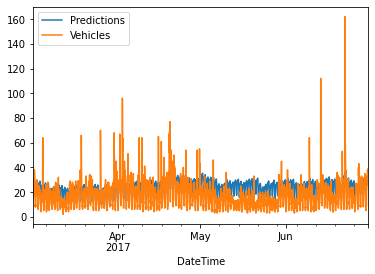

In [101]:
start=len(train)
end=len(train)+len(test)-1
#index_future_dates=pd.date_range(start='2015-11-01',end='2017-06-30')

pred=model.predict(exog = test[b], start=start,end=end,typ='levels').rename('ARIMA predictions')
preds= pd.DataFrame(columns=['DateTime', 'Predictions'])
preds.Predictions = pred
test_index= test.reset_index()
test_index = test_index['DateTime']
preds.DateTime= list (test_index)
preds.set_index('DateTime', inplace=True, drop=True)
#pred.index=list (test_index)
preds.plot(legend=True)
test['Vehicles'].plot(legend=True)

In [102]:
ARIMA_RMSE= mean_squared_error(test['Vehicles'], abs(pred), squared=False)
ARIMA_MAPE= mean_absolute_percentage_error(test['Vehicles'], abs(pred))*100
print("RMSE of ARIMAX:", ARIMA_RMSE)
print("MAPE of ARIMAX:", ARIMA_MAPE)


RMSE of ARIMAX: 10.275441769739652
MAPE of ARIMAX: 70.13281725794866


In [103]:
model_performance = pd.DataFrame({
    "Model": ["LinearRegression","Lasso", "Ridge","CatBoost", "RandomForest", "DecisionTree", "SVR", "LinearSVR", 
              "AdaBoost", "GradientBoosting", "LGBM", "XGBoost", 'Prophet', 'ARIMAX'],
        
    "RMSE": [lg_RMSE, l_RMSE, rr_RMSE, 
              cat_RMSE, rf_RMSE, dt_RMSE, svc_RMSE, lsvc_RMSE, ab_RMSE, nb_RMSE, lgb_RMSE, xg_RMSE, prof_RMSE, ARIMA_RMSE],
    'MAPE': [lg_MAPE, l_MAPE, rr_MAPE, 
              cat_MAPE, rf_MAPE, dt_MAPE, svc_MAPE, lsvc_MAPE, ab_MAPE, nb_MAPE, lgb_MAPE, xg_MAPE, prof_MAPE, ARIMA_MAPE]
    })

model_performance['Average Score']= (model_performance['RMSE']+model_performance['MAPE'])/2

model_performance = model_performance.sort_values(['Average Score'])
    
display(model_performance)

,Model,RMSE,MAPE,Average Score
10,LGBM,9.437156,39.265525,24.351340
0,LinearRegression,8.418616,41.727789,25.073203
2,Ridge,8.529475,44.654804,26.592139
3,CatBoost,10.028169,45.982760,28.005465
6,SVR,12.075476,44.539007,28.307241
9,GradientBoosting,9.925743,46.990505,28.458124
1,Lasso,8.581689,49.206843,28.894266
4,RandomForest,11.028847,52.278331,31.653589
11,XGBoost,10.644478,57.295947,33.970212
13,ARIMAX,10.275442,70.132817,40.204130


## Choosing the final model and Tuning it for Junction 3

In [104]:
# LGBM
lgb = LGBMRegressor(learning_rate=0.0099)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')

print('--------'*20)

Average:  21.29710460954884
LGBM RMSE score on validation set is :  9.206739450799182
LGBM MAPE score on validation set is :  33.387469768298494 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------


### Checking Feature Importance and Removing Useless Features

In [105]:
cat_viz= pd.DataFrame({'Feature':X.columns, 'Importance':lgb.feature_importances_}).sort_values(by="Importance",ascending=False)
cat_viz

,Feature,Importance
0,DateTime,426
38,day_of_yearmedian_vehicles,419
35,day_of_yearmax_vehicles,341
6,Time,306
4,day_of_week,260
29,Timestd_vehicles,191
37,day_of_yearmean_vehicles,179
5,Date,153
8,day_of_year,136
9,Monthstd_vehicles,129


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

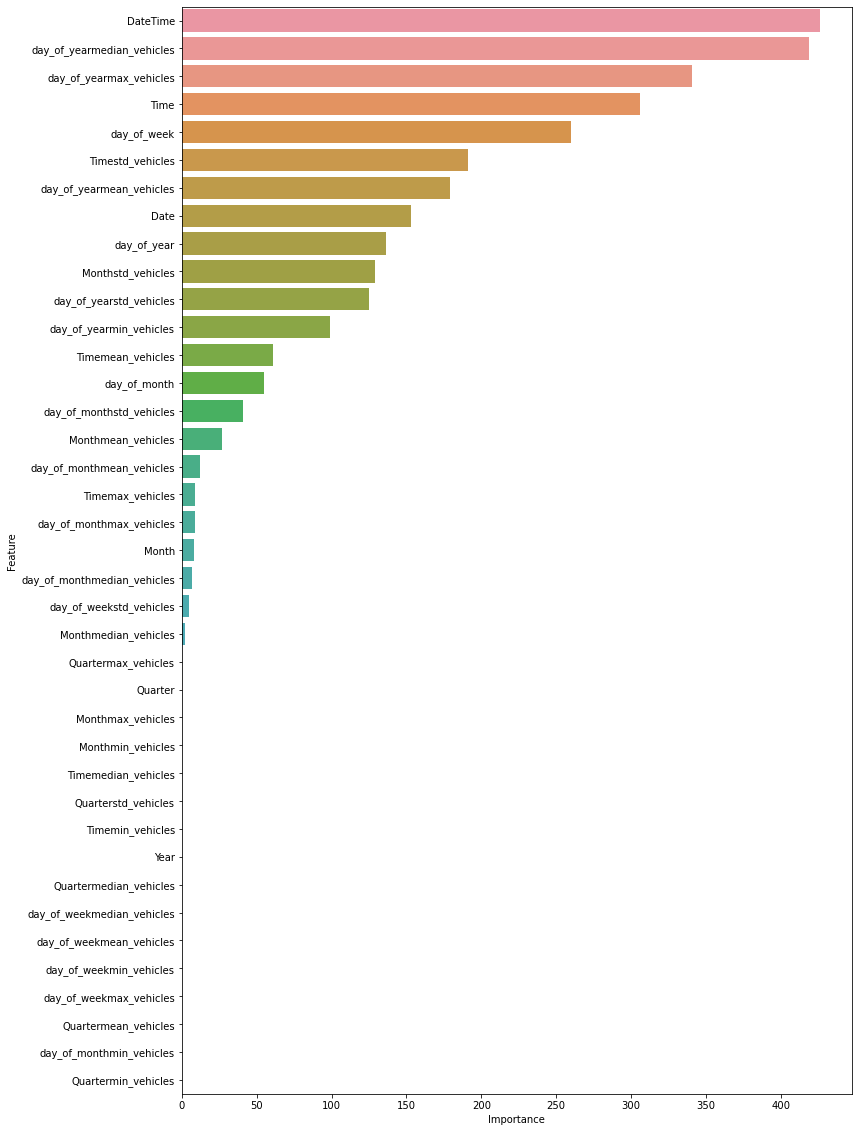

In [106]:
plt.figure(figsize= (12,20))
sns.barplot(x='Importance', y= 'Feature', data=cat_viz, label="Feature Importances", orient= 'h')#, color_palette='tab10')
#sns.set_color_palette('hls', 8)

In [107]:
useless_cols3 = list(cat_viz.loc[cat_viz['Importance']==0.00000000000000]['Feature'])
X1= X.drop(useless_cols3,axis=1).reset_index(drop=True)
X_train=X1.iloc[:a]
y_train= y.iloc[:a]
X_valid=X1.iloc[a:]
y_valid=y.iloc[a:]

# LGBM
lgb = LGBMRegressor(learning_rate=0.0099)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')

print('--------'*20)

Average:  21.29710460954884
LGBM RMSE score on validation set is :  9.206739450799182
LGBM MAPE score on validation set is :  33.387469768298494 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------


### Cross Validation for Junction 3

In [108]:
preds = cross_val(X1 ,y , model =LGBMRegressor(learning_rate=0.0099))

Number of splits trained : 0 	 RMSE:  8.043832732849028  	 MAPE: 48.273205193489375  	 MAE: 4.8090642140154305
Number of splits trained : 1 	 RMSE:  9.49538132586139  	 MAPE: 43.44326838563969  	 MAE: 5.588388512540643
Number of splits trained : 2 	 RMSE:  7.004194355194533  	 MAPE: 35.92990268050485  	 MAE: 4.267102446858481
Number of splits trained : 3 	 RMSE:  9.901594370729015  	 MAPE: 50.077064824386156  	 MAE: 4.9715043289565894
Number of splits trained : 4 	 RMSE:  7.061474107244829  	 MAPE: 28.70698544350347  	 MAE: 3.9276800883588763
Number of splits trained : 5 	 RMSE:  7.240087707868805  	 MAPE: 26.493448666962433  	 MAE: 3.727759502506538
Number of splits trained : 6 	 RMSE:  10.490723506803665  	 MAPE: 28.574122363054187  	 MAE: 5.0304739458278975
Number of splits trained : 7 	 RMSE:  10.652921580760522  	 MAPE: 29.577375170073516  	 MAE: 5.135243544986525
Number of splits trained : 8 	 RMSE:  10.052411896717292  	 MAPE: 27.17413315443097  	 MAE: 6.1894246279896015
Number 

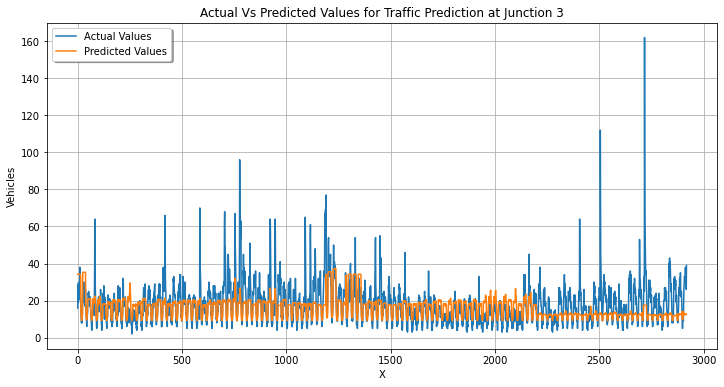

In [109]:
# visualizing in a plot
x_ax = range(len(y_valid))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_valid, label="Actual Values")
plt.plot(x_ax, lgb_pred, label="Predicted Values")
plt.title("Actual Vs Predicted Values for Traffic Prediction at Junction 3")
plt.xlabel('X')
plt.ylabel('Vehicles')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## Exporting the Junction 3 Model

In [110]:
import pickle
pickle_out = open("junction3_model.pkl","wb")
pickle.dump(lgb, pickle_out)
pickle_out.close()

In [111]:
useless_cols3


['Quartermax_vehicles',
 'Quarter',
 'Monthmax_vehicles',
 'Monthmin_vehicles',
 'Timemedian_vehicles',
 'Quarterstd_vehicles',
 'Timemin_vehicles',
 'Year',
 'Quartermedian_vehicles',
 'day_of_weekmedian_vehicles',
 'day_of_weekmean_vehicles',
 'day_of_weekmin_vehicles',
 'day_of_weekmax_vehicles',
 'Quartermean_vehicles',
 'day_of_monthmin_vehicles',
 'Quartermin_vehicles']

# Building Model for Junction 4

In [112]:
X = df_junc4.drop(['Vehicles','Seconds', 'ID', 'Junction'], axis=1)
y = df_junc4['Vehicles']

In [113]:
a= ceil(0.8 * len(df_junc4))

In [114]:
X_train=X.iloc[:a]
y_train= y.iloc[:a]
X_valid=X.iloc[a:]
y_valid=y.iloc[a:]

# Checking Performance of Baseline Models for Junction 4

In [115]:
#LinearRegression
lg =  LinearRegression()
lg.fit(X_train, y_train)
lg_pred = lg.predict(X_valid)
lg_RMSE = mean_squared_error(y_valid,lg_pred, squared=False)
lg_MAPE= mean_absolute_percentage_error(y_valid,lg_pred)*100

print("LinearRegression RMSE score on validation set is : ",lg_RMSE)
print("LinearRegression MAPE score on validation set is : ",lg_MAPE, '%')

print('--------'*20) 

#LassoRegression
l =  Lasso()
l.fit(X_train, y_train)
l_pred = l.predict(X_valid)
l_RMSE = mean_squared_error(y_valid,l_pred, squared=False)
l_MAPE= mean_absolute_percentage_error(y_valid,l_pred)*100

print("LassoRegression RMSE score on validation set is : ",l_RMSE)
print("LassoRegression MAPE score on validation set is : ",l_MAPE, '%')

print('--------'*20) 

#RidgeRegression
rr =  Ridge()
rr.fit(X_train, y_train)
rr_pred = rr.predict(X_valid)
rr_RMSE = mean_squared_error(y_valid,rr_pred, squared=False)
rr_MAPE= mean_absolute_percentage_error(y_valid,rr_pred)*100

print("RidgeRegression RMSE score on validation set is : ",rr_RMSE)
print("RidgeRegression MAPE score on validation set is : ",rr_MAPE, '%')

print('--------'*20) 


# Catboost
cat = CatBoostRegressor(verbose=False, iterations=100)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)
cat_RMSE = mean_squared_error(y_valid,cat_pred, squared=False)
cat_MAPE= mean_absolute_percentage_error(y_valid,cat_pred)*100

print("CatBoost RMSE score on validation set is : ",cat_RMSE)
print("CatBoost MAPE score on validation set is : ",cat_MAPE, '%')

print('--------'*20)

# LGBM
lgb = LGBMRegressor()#num_iterations=1000)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100

print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE, '%')

print('--------'*20)

# XGBoost
xg = XGBRegressor()#n_estimators=1000)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_valid)
xg_RMSE = mean_squared_error(y_valid,xg_pred, squared=False)
xg_MAPE= mean_absolute_percentage_error(y_valid,xg_pred)*100

print("XGBoost RMSE score on validation set is : ",xg_RMSE)
print("XGBoost MAPE score on validation set is : ",xg_MAPE, '%')

print('--------'*20)


#AdaBoost
ab =  AdaBoostRegressor()
ab.fit(X_train, y_train)
ab_pred = ab.predict(X_valid)
ab_RMSE = mean_squared_error(y_valid,ab_pred, squared=False)
ab_MAPE= mean_absolute_percentage_error(y_valid,ab_pred)*100

print("AdaBoost RMSE score on validation set is : ",ab_RMSE)
print("AdaBoost MAPE score on validation set is : ",ab_MAPE, '%')

print('--------'*20)



#Naive Bayes
nb =  GradientBoostingRegressor()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_valid)
nb_RMSE = mean_squared_error(y_valid,nb_pred, squared=False)
nb_MAPE= mean_absolute_percentage_error(y_valid,nb_pred)*100

print("Gradient Boosting RMSE score on validation set is : ",nb_RMSE)
print("Gradient Boosting MAPE score on validation set is : ",nb_MAPE, '%')

print('--------'*20)

#DecisionTree
dt =  DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_valid)
dt_RMSE = mean_squared_error(y_valid,dt_pred, squared=False)
dt_MAPE= mean_absolute_percentage_error(y_valid,dt_pred)*100

print("DecisionTree RMSE score on validation set is : ",dt_RMSE)
print("DecisionTree MAPE score on validation set is : ",dt_MAPE, '%')

print('--------'*20)

#RandomForest
rf =  RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_RMSE = mean_squared_error(y_valid,rf_pred, squared=False)
rf_MAPE= mean_absolute_percentage_error(y_valid,rf_pred)*100

print("RandomForest RMSE score on validation set is : ",rf_RMSE)
print("RandomForest MAPE score on validation set is : ",rf_MAPE, '%')

print('--------'*20)



#SVC
svc =  SVR()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_valid)
svc_RMSE = mean_squared_error(y_valid,svc_pred, squared=False)
svc_MAPE= mean_absolute_percentage_error(y_valid,svc_pred)*100

print("SVC RMSE score on validation set is : ",svc_RMSE)
print("SVC MAPE score on validation set is : ",svc_MAPE, '%')

print('--------'*20)

#LinearSVC
lsvc =  LinearSVR()
lsvc.fit(X_train, y_train)
lsvc_pred = lsvc.predict(X_valid)
lsvc_RMSE = mean_squared_error(y_valid,lsvc_pred, squared=False)
lsvc_MAPE= mean_absolute_percentage_error(y_valid,lsvc_pred)*100
print("LinearSVC RMSE score on validation set is : ",lsvc_RMSE)
print("LinearSVC MAPE score on validation set is : ",lsvc_MAPE, '%')

print('--------'*20)



LinearRegression RMSE score on validation set is :  3.646906308065977
LinearRegression MAPE score on validation set is :  31.399350412569294 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
LassoRegression RMSE score on validation set is :  3.691967997087228
LassoRegression MAPE score on validation set is :  31.641517694440687 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
RidgeRegression RMSE score on validation set is :  3.646824566387416
RidgeRegression MAPE score on validation set is :  31.389218800647022 %
----------------------------------------------------------------------------------------------------------------------------------------------------------------
CatBoost RMSE score on validation set is :  3.5471524124797567
CatBoost MAPE score on valida

## Building Prophet Model for Junction 4

In [116]:
a= ceil(0.8 * len(df_junc4))
a

3476

In [117]:
train=df_junc4.iloc[:a]
test=df_junc4.iloc[a:]

train['DateTime'] =list(df1.loc[df1['Junction']==4]['DateTime'].iloc[:a])
test['DateTime'] =list(df1.loc[df1['Junction']==4]['DateTime'].iloc[a:])

train.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
test.drop(['Seconds', 'ID', 'Junction'], axis=1, inplace=True)
train = train.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})
test = test.rename(columns = {"DateTime" : "ds", "Vehicles" : "y"})

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [118]:
model = Prophet(yearly_seasonality=True)
for col in train.columns:
    if col != 'y' and col != 'ds':
        model.add_regressor(col)
model.fit(train)


16:23:07 - cmdstanpy - INFO - Chain [1] start processing
16:23:09 - cmdstanpy - INFO - Chain [1] done processing


In [119]:
# making predictions for the next 10 months
X_test = test.drop('y', axis=1)
y_test= test['y']

forecast = model.predict(X_test)
pred = forecast['yhat']
forecast[[ 'ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'trend_lower', 'trend_upper' ]].head()

,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
0,2017-05-25 20:00:00,8.078016,4.992127,11.070057,14.768724,14.768724,14.768724
1,2017-05-25 21:00:00,8.138585,4.912919,11.038708,14.773218,14.773218,14.773218
2,2017-05-25 22:00:00,8.113470,4.971119,11.344679,14.777713,14.777713,14.777713
3,2017-05-25 23:00:00,8.026585,4.888682,11.190021,14.782207,14.782207,14.782207
4,2017-05-26 00:00:00,6.110630,3.004585,9.190369,14.786701,14.786701,14.786701


In [120]:
prof_MAPE= mean_absolute_percentage_error(y_test,pred)*100
print("Prophet Model MAPE score on validation set is : {:.2f} ".format(prof_MAPE))

Prophet Model MAPE score on validation set is : 46.24 


In [121]:
prof_RMSE= mean_squared_error(y_test,pred, squared=False)
print("Prophet Model RMSE score on validation set is : {:.2f} ".format(prof_RMSE))

Prophet Model RMSE score on validation set is : 3.40 


## Building an ARIMAX Model for Junction 4

In [122]:
df_junc41 = df_junc4.drop(['Seconds', 'ID', 'Junction'], axis=1) 
df_junc41['DateTime'] =list(df1.loc[df1['Junction']==4]['DateTime'])

In [123]:
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

In [124]:
adf_test(df_junc41['Vehicles'])

1. ADF :  -6.726732196265554
2. P-Value :  3.374874583448731e-09
3. Num Of Lags :  30
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 4313
5. Critical Values :
	 1% :  -3.431867086998538
	 5% :  -2.862210364905111
	 10% :  -2.567126840085047


In [125]:
df_junc41.set_index('DateTime', inplace = True, drop = True)

In [126]:
df_junc41= df_junc41.reset_index()
a= ceil(0.8 * len(df_junc41))
train=df_junc41.iloc[:a]
test=df_junc41.iloc[a:]
train.set_index('DateTime', inplace=True, drop=True)
test.set_index('DateTime', inplace=True, drop=True)

test.head()

,Vehicles,Year,Month,day_of_month,day_of_week,Date,Time,Quarter,day_of_year,Monthstd_vehicles,...,Timestd_vehicles,Timemax_vehicles,Timemin_vehicles,Timemean_vehicles,Timemedian_vehicles,day_of_yearstd_vehicles,day_of_yearmax_vehicles,day_of_yearmin_vehicles,day_of_yearmean_vehicles,day_of_yearmedian_vehicles
DateTime,,,,,,,,,,,,,,,,,,,,,
2017-05-25 20:00:00,10,2017,5,25,3,571,20,2,145,23.33728,...,25.446722,173.0,1.0,29.824938,19.0,28.330084,128.0,2.0,28.071428,16.0
2017-05-25 21:00:00,10,2017,5,25,3,571,21,2,145,23.33728,...,23.654558,125.0,2.0,28.202993,19.0,28.330084,128.0,2.0,28.071428,16.0
2017-05-25 22:00:00,9,2017,5,25,3,571,22,2,145,23.33728,...,22.178799,111.0,1.0,27.226933,18.0,28.330084,128.0,2.0,28.071428,16.0
2017-05-25 23:00:00,7,2017,5,25,3,571,23,2,145,23.33728,...,20.715092,99.0,1.0,25.635412,17.0,28.330084,128.0,2.0,28.071428,16.0
2017-05-26 00:00:00,5,2017,5,26,4,572,0,2,146,23.33728,...,19.148046,109.0,1.0,23.540648,16.0,24.738934,101.0,2.0,25.761906,15.0


In [127]:
b= []

for col in train.columns:
    if col != 'Vehicles':
        b.append(col)

In [128]:
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(train['Vehicles'], exogenous = train[b], trace=True,
                          suppress_warnings=True)           

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16648.239, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17256.223, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16775.019, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16644.907, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17254.224, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16644.457, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16645.357, Time=1.65 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16644.640, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16664.681, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16642.465, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16642.914, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16773.022, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(1,1,2)(0,0,0)[0]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3476
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -8318.233
Date:                Tue, 18 Oct 2022   AIC                          16642.465
Time:                        16:23:23   BIC                          16660.925
Sample:                    01-01-2017   HQIC                         16649.056
                         - 05-25-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0706      0.030      2.385      0.017       0.013       0.129
ma.L1         -0.5098      0.024    -21.294      0.000      -0.557      -0.463
sigma2         7.0253      0.093     75.531      0.000       6.843       7.208
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3406.84
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.70
Prob(H) (two-sided):                  0.20   Kurtosis:                         7.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [129]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train['Vehicles'], exog = train[b],order=(1,1,1))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               Vehicles   No. Observations:                 3476
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7842.256
Date:                Tue, 18 Oct 2022   AIC                          15766.513
Time:                        16:23:49   BIC                          16018.800
Sample:                    01-01-2017   HQIC                         15856.584
                         - 05-25-2017                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Year                         7.321e-05    412.170   1.78e-07      1.000    -807.839     807.839
Month                           0.0011      1.306      0.001      0.999      -2.559       2.561
day_of_month                   -0.0423      0.028     -1.488      0.137      -0.098       0.013
day_of_week                    -0.2821      0.154     -1.836      0.066      -0.583       0.019
Date                            0.0027     43.529   6.11e-05      1.000     -85.312      85.318
Time                            0.0128      0.011      1.127      0.260      -0.009       0.035
Quarter                        -0.0014      2.020     -0.001      0.999      -3.960       3.958
day_of_year                     0.0026     43.522   6.08e-05      1.000     -85.298      85.303
Monthstd_vehicles              -0.0652      0.644     -0.101      0.919      -1.328       1.198
Monthmax_vehicles               0.0118      0.021      0.572      0.567      -0.029       0.052
Monthmin_vehicles             3.52e-08      0.204   1.72e-07      1.000      -0.401       0.401
Monthmean_vehicles              0.0933      0.153      0.609      0.542      -0.207       0.393
Monthmedian_vehicles            0.1749      0.317      0.552      0.581      -0.446       0.796
Quarterstd_vehicles            -0.0041      9.363     -0.000      1.000     -18.355      18.347
Quartermax_vehicles             0.0254      4.103      0.006      0.995      -8.016       8.067
Quartermin_vehicles          3.527e-08      0.204   1.73e-07      1.000      -0.401       0.401
Quartermean_vehicles           -0.0044     10.182     -0.000      1.000     -19.961      19.952
Quartermedian_vehicles         -0.0028      6.696     -0.000      1.000     -13.128      13.122
day_of_monthstd_vehicles       -0.4769      0.260     -1.835      0.066      -0.986       0.032
day_of_monthmax_vehicles       -0.0161      0.007     -2.349      0.019      -0.029      -0.003
day_of_monthmin_vehicles       -0.0619      0.678     -0.091      0.927      -1.391       1.268
day_of_monthmean_vehicles       1.8911      0.411      4.596      0.000       1.085       2.698
day_of_monthmedian_vehicles    -1.0770      0.269     -4.006      0.000      -1.604      -0.550
day_of_weekstd_vehicles        -0.0806      0.603     -0.134      0.894      -1.263       1.102
day_of_weekmax_vehicles         0.0028      0.008      0.364      0.716      -0.012       0.018
day_of_weekmin_vehicles      3.338e-08      0.204   1.63e-07      1.000      -0.401       0.401
day_of_weekmean_vehicles        0.5166      0.981      0.527      0.598      -1.406       2.439
day_of_weekmedian_vehicles     -0.7737      0.837     -0.924      0.355      -2.414       0.867
Timestd_vehicles                0.0626      0.133      0.471      0.637      -0.198       0.323
Timemax_vehicles               -0.0100      0.004     -2.843      0.004      -0.017      -0.003
Timemin_vehicles                0.2387      0.085      2.801      0.005  

<AxesSubplot:xlabel='DateTime'>

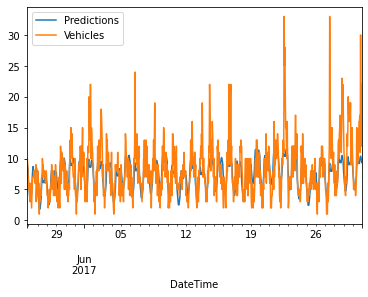

In [130]:
start=len(train)
end=len(train)+len(test)-1
#index_future_dates=pd.date_range(start='2015-11-01',end='2017-06-30')

pred=model.predict(exog = test[b], start=start,end=end,typ='levels').rename('ARIMA predictions')
preds= pd.DataFrame(columns=['DateTime', 'Predictions'])
preds.Predictions = pred
test_index= test.reset_index()
test_index = test_index['DateTime']
preds.DateTime= list (test_index)
preds.set_index('DateTime', inplace=True, drop=True)
#pred.index=list (test_index)
preds.plot(legend=True)
test['Vehicles'].plot(legend=True)

In [131]:
ARIMA_RMSE= mean_squared_error(test['Vehicles'], pred, squared=False)
ARIMA_MAPE= mean_absolute_percentage_error(test['Vehicles'], pred)*100
print("RMSE of ARIMAX:", ARIMA_RMSE)
print("MAPE of ARIMAX:", ARIMA_MAPE)


RMSE of ARIMAX: 3.4219774955642537
MAPE of ARIMAX: 33.17942309583562


In [132]:
model_performance = pd.DataFrame({
    "Model": ["LinearRegression","Lasso", "Ridge","CatBoost", "RandomForest", "DecisionTree", "SVR", "LinearSVR", 
              "AdaBoost", "GradientBoosting", "LGBM", "XGBoost", 'Prophet', 'ARIMAX'],
        
    "RMSE": [lg_RMSE, l_RMSE, rr_RMSE, 
              cat_RMSE, rf_RMSE, dt_RMSE, svc_RMSE, lsvc_RMSE, ab_RMSE, nb_RMSE, lgb_RMSE, xg_RMSE, prof_RMSE, ARIMA_RMSE],
    'MAPE': [lg_MAPE, l_MAPE, rr_MAPE, 
              cat_MAPE, rf_MAPE, dt_MAPE, svc_MAPE, lsvc_MAPE, ab_MAPE, nb_MAPE, lgb_MAPE, xg_MAPE, prof_MAPE, ARIMA_MAPE]
    })

model_performance['Average Score']= (model_performance['RMSE']+model_performance['MAPE'])/2

model_performance = model_performance.sort_values(['Average Score'])
    
display(model_performance)

,Model,RMSE,MAPE,Average Score
10,LGBM,3.279228,28.993053,16.136140
9,GradientBoosting,3.298566,29.364646,16.331606
4,RandomForest,3.303135,30.246825,16.774980
2,Ridge,3.646825,31.389219,17.518022
0,LinearRegression,3.646906,31.399350,17.523128
3,CatBoost,3.547152,31.749286,17.648219
1,Lasso,3.691968,31.641518,17.666743
13,ARIMAX,3.421977,33.179423,18.300700
11,XGBoost,3.330306,33.964769,18.647538
8,AdaBoost,3.366164,40.539051,21.952608


## Choosing the final model and Tuning it for Junction 4

In [133]:

# LGBM
X_train=X.iloc[:a]
y_train= y.iloc[:a]
X_valid=X.iloc[a:]
y_valid=y.iloc[a:]
lgb = LGBMRegressor(num_iterations=69, learning_rate=0.099)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred)*100
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE) 
print("LGBM MAE score on validation set is : ",lgb_MAE)
print('--------'*20)

Average:  15.966648266271397
LGBM RMSE score on validation set is :  3.2529932481387176
LGBM MAPE score on validation set is :  28.680303284404076
LGBM MAE score on validation set is :  4.60665376811428
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [134]:
cat_viz= pd.DataFrame({'Feature':X.columns, 'Importance':lgb.feature_importances_}).sort_values(by="Importance",ascending=False)
cat_viz

,Feature,Importance
0,DateTime,293
6,Time,267
29,Timestd_vehicles,170
34,day_of_yearstd_vehicles,158
37,day_of_yearmean_vehicles,154
19,day_of_monthstd_vehicles,105
35,day_of_yearmax_vehicles,103
30,Timemax_vehicles,98
3,day_of_month,92
38,day_of_yearmedian_vehicles,84


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

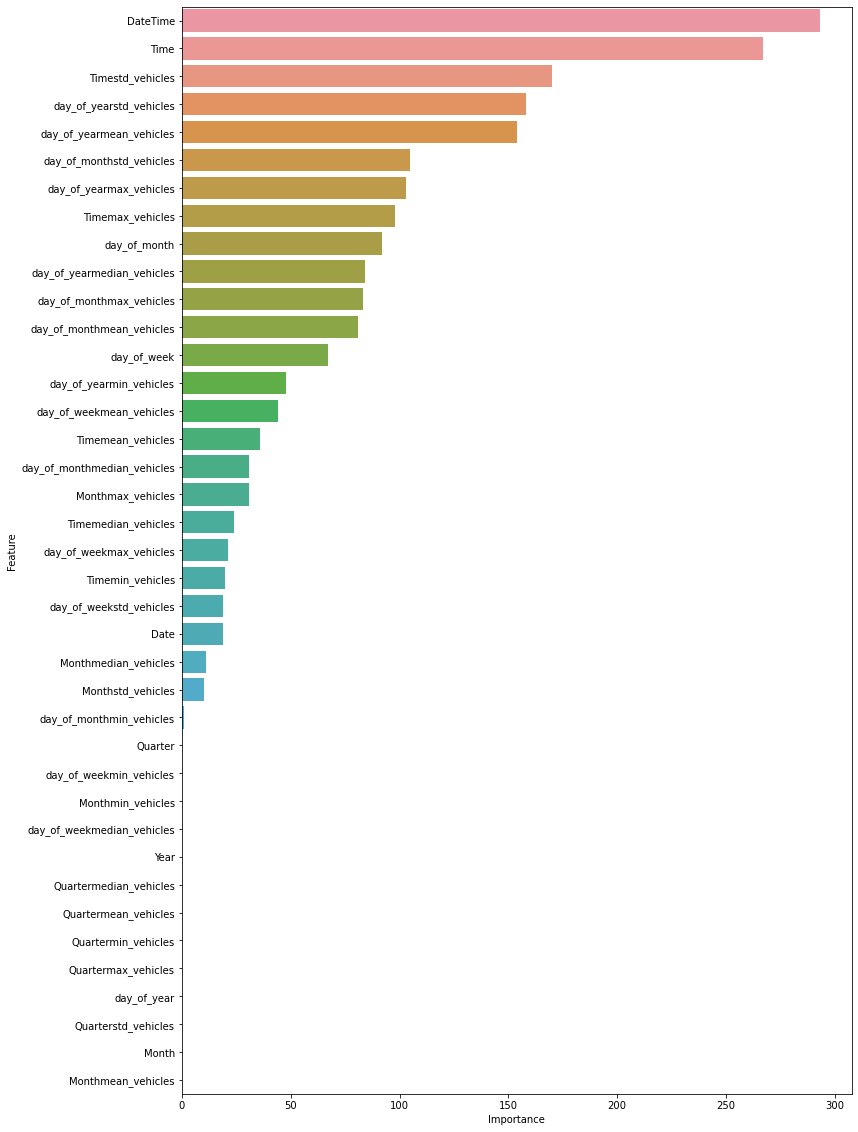

In [135]:
plt.figure(figsize= (12,20))
sns.barplot(x='Importance', y= 'Feature', data=cat_viz, label="Feature Importances", orient= 'h')#, color_palette='tab10')
#sns.set_color_palette('hls', 8)

In [136]:
useless_cols = list(cat_viz.loc[cat_viz['Importance']==0.00000000000000]['Feature'])


### Checking Feature Importance and Removing Useless Features

In [137]:
useless_cols4 = list(cat_viz.loc[cat_viz['Importance']==0.00000000000000]['Feature'])
X1= X.drop(useless_cols4,axis=1).reset_index(drop=True)
X_train=X1.iloc[:a]
y_train= y.iloc[:a]
X_valid=X1.iloc[a:]
y_valid=y.iloc[a:]


# LGBM
lgb = LGBMRegressor(num_iterations=69, learning_rate=0.099)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
lgb_MAPE= mean_absolute_percentage_error(y_valid,lgb_pred) *100
lgb_MAE= mean_absolute_error(y_valid,lgb_pred)
average = (lgb_RMSE+lgb_MAPE)/2
print('Average: ', average)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print("LGBM MAPE score on validation set is : ",lgb_MAPE)
print("LGBM MAE score on validation set is : ",lgb_MAE)
print('--------'*20)


Average:  15.966648266271397
LGBM RMSE score on validation set is :  3.2529932481387176
LGBM MAPE score on validation set is :  28.680303284404076
LGBM MAE score on validation set is :  2.2037638407648767
----------------------------------------------------------------------------------------------------------------------------------------------------------------


### Cross Validation for Junction 4

In [138]:
preds = cross_val(X1 ,y , model = LGBMRegressor(num_iterations=69, learning_rate=0.099))

Number of splits trained : 0 	 RMSE:  2.576129413621712  	 MAPE: 32.35478792848445  	 MAE: 1.998430997671927
Number of splits trained : 1 	 RMSE:  3.2969725300594015  	 MAPE: 32.22063123262595  	 MAE: 2.308141234818858
Number of splits trained : 2 	 RMSE:  3.261055272741902  	 MAPE: 37.51408309114382  	 MAE: 2.4107031103179035
Number of splits trained : 3 	 RMSE:  2.611372304772255  	 MAPE: 43.22358271771506  	 MAE: 2.0590014953418816
Number of splits trained : 4 	 RMSE:  2.129137999323275  	 MAPE: 40.227432627101855  	 MAE: 1.7075444806253102
Number of splits trained : 5 	 RMSE:  2.9725287248376624  	 MAPE: 34.51677671826895  	 MAE: 1.8705687388717027
Number of splits trained : 6 	 RMSE:  2.5410590860429614  	 MAPE: 35.921673189351324  	 MAE: 1.8248773848445923
Number of splits trained : 7 	 RMSE:  1.9842063959829364  	 MAPE: 35.978536055057965  	 MAE: 1.5989413788895945
Number of splits trained : 8 	 RMSE:  2.889670274976132  	 MAPE: 28.10170301223547  	 MAE: 2.0643785970966966
Numbe

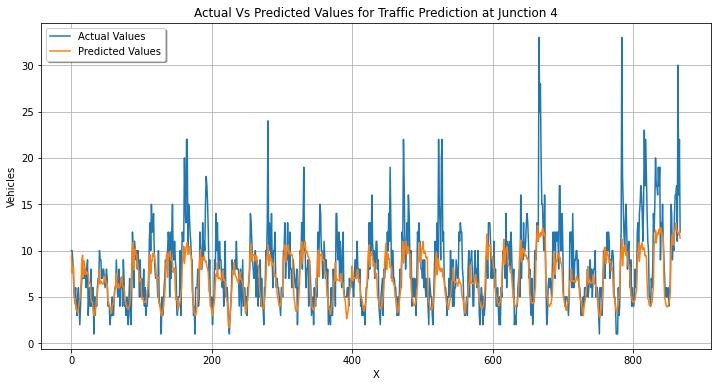

In [139]:
# visualizing in a plot
x_ax = range(len(y_valid))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_valid, label="Actual Values")
plt.plot(x_ax, lgb_pred, label="Predicted Values")
plt.title("Actual Vs Predicted Values for Traffic Prediction at Junction 4")
plt.xlabel('X')
plt.ylabel('Vehicles')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

## Exporting the Junction 4 Model

In [140]:
import pickle
pickle_out = open("junction4_model.pkl","wb")
pickle.dump(lgb, pickle_out)
pickle_out.close()

In [141]:
useless_cols1

['Quartermedian_vehicles',
 'day_of_weekmin_vehicles',
 'Quartermax_vehicles',
 'Quarter',
 'Quartermin_vehicles',
 'day_of_weekmedian_vehicles']

In [142]:
useless_cols2

['Year',
 'Quartermax_vehicles',
 'Quartermedian_vehicles',
 'day_of_weekmedian_vehicles',
 'day_of_weekmin_vehicles',
 'Quartermin_vehicles',
 'Quarter']

In [143]:
useless_cols3

['Quartermax_vehicles',
 'Quarter',
 'Monthmax_vehicles',
 'Monthmin_vehicles',
 'Timemedian_vehicles',
 'Quarterstd_vehicles',
 'Timemin_vehicles',
 'Year',
 'Quartermedian_vehicles',
 'day_of_weekmedian_vehicles',
 'day_of_weekmean_vehicles',
 'day_of_weekmin_vehicles',
 'day_of_weekmax_vehicles',
 'Quartermean_vehicles',
 'day_of_monthmin_vehicles',
 'Quartermin_vehicles']

In [144]:
useless_cols4

['Quarter',
 'day_of_weekmin_vehicles',
 'Monthmin_vehicles',
 'day_of_weekmedian_vehicles',
 'Year',
 'Quartermedian_vehicles',
 'Quartermean_vehicles',
 'Quartermin_vehicles',
 'Quartermax_vehicles',
 'day_of_year',
 'Quarterstd_vehicles',
 'Month',
 'Monthmean_vehicles']

# Conclusion 

**Creating New Features by Target Encoding Some Features and Extracting from DateTime**

First, new features like Day of week, Day of Month, Quarter, Month and Time were extracted from the DateTime column and then target Encoding was used to create new features with aggregates : Std, Max,Min, Mean and Median.


**Seperating the dataset based on junctions**

We created 4 datasets from the original dataset, one for each junction and then dropped the ID and Junction column.This is done because we are building 4 models, one for each junctions. Based on our dataset, the data for each hour was provided for all the junctions hence we had more that one observation for one particular time. 


**Building Baseline Models for each junction to check their performance and choose the best performing one**

A Baseline Models was built and the Root Mean Square Error(RMSE) and Mean Absolute Percentage Error (MAPE) was used as evaluation metrics to choose the best performing models. The lower the value of the RMSE and MAPE, the better performing the model was. For Junction 2,3 and 4, the best performing baseline model was LGBM. 


**Tuning Hyperparameters for the Chosen Model** 

For Junction 2,3 and 4, the best performing baseline model was LGBM so we tuned LGBM parameters for that directly. 

But for Junction 1, the best performing baseline model was RandomForest, followed closely by LGBM, but ultimately we chose LGBM for a particular reason. The reason was that RandomForest is well-known to have great baseline performances but yields lesser improvement in performance with tuning compared to Gradient Boosted Models like CatBoost, LGBM and XGBoost and after tuning both LGBM and RandomForest, we were able to get LGBM to outperform  RandomForest and so LGBM was chosen as our model for Junction 1 as well. 


**Checking for Overfitting with TimeSeries Cross Validation and Choosing the Best Model**

None of the models was overfitting after we tested with TimeSeries cross-validation. 


**Checking Feature Importance to get rid of unimportant Features**

The importance of all the features were checked to see which ones added noise to our models and we noticed the features with no importance to the models and dropped them.
